# Predicting DG Errors

Through the use of topological indices, we try to predict the errors of DG algorithms. Previously we have already generated the DG errors for our molecules, and saved them in $\texttt{./output/}$

In [44]:
from dg_functions import chemspace_root, chemspace_paths
from indices import all_indices
from dg_processing import LogTransformer, describe_losses, avg_corr, plot_losses_together, feasibility_vector, classification_metrics
from dg_processing import evaluate_classifier, evaluate_classifier_and_get_results, cross_validate_classifier

# standard functions for data analysis
import numpy as np, pandas as pd
import scipy.stats
import pickle
import time, logging
import pprint as pp
from functools import reduce

# Chemistry libraries 
from rdkit import Chem
from rdkit.Chem import Draw
from openbabel import openbabel as ob, pybel

# Simple ML libraries
import sklearn
from sklearn import linear_model, metrics, tree, ensemble, neural_network, neighbors, svm
from sklearn import pipeline, decomposition
from sklearn import model_selection
from sklearn.inspection import permutation_importance
# enable use of ensemble.HistGradientBoosting{Classifier, Regressor}
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.utils.fixes import loguniform # hyperparameter search

# plotting
import matplotlib.pyplot as plt
import matplotlib # for LaTeX display
import graphviz

In [45]:
# ignore sklearn warnings for now
import warnings
warnings.filterwarnings('ignore') 
pd.set_option('display.max_colwidth', -1)

In [46]:
logging.basicConfig(filename='logs/dg-error-prediction-all-descs.log',
                    level=logging.DEBUG,
                    format='%(asctime)s %(levelname)s: %(message)s')

In [47]:
chemspace_names = ['c5h6', 'c6h6', '125_56k', '125_338k']

# Loading Chemical Spaces

In [48]:
chemspace = {}
for name in chemspace_names:
    chemspace[name] = {'mols': Chem.SmilesMolSupplier(chemspace_paths[name], delimiter='\t')}

# Loading Conformation / Indices Data

The conformations (from DG) and topological indices of the molecules has been calculated, we load them up:

In [49]:
losses_names = ['length_loss', 'angle_loss', 'energy_loss']
for name in chemspace_names:
    # unpickle the saved indices and conformation data
    with open(f'./output/descriptors_and_maccs/{name}_descriptors', 'rb') as f:        
        feature_names, features, invalids = pickle.load(f)
        chemspace[name]['features'] = pd.DataFrame(features[:, 1:], 
                                                   index=features[:, 0], columns=feature_names)
        
    with open(f'./output/avg_distance_error_bonds_avg_angle_error_by_degree_uff/{name}', 'rb') as f:
        losses, reading_failed, conformation_failed = pickle.load(f)
        chemspace[name]['dg_loss'] = losses
        chemspace[name]['failed_conformation'] = conformation_failed
        
    # molecules that either could not be read when computing indices, or in conformations
    chemspace[name]['invalid'] = list(set().union(invalids, reading_failed))
    
    # Form the losses datafame (with values np.nan or the loss for every molecule)
    df_losses = pd.DataFrame(chemspace[name]['dg_loss'][:, 1:], 
                             index=chemspace[name]['dg_loss'][:, 0], columns=losses_names)
    df_failures = pd.DataFrame(np.nan, index=set().union(chemspace[name]['failed_conformation'], chemspace[name]['invalid']),
                               columns=losses_names)
    chemspace[name]['dg_loss'] = pd.concat([df_losses, df_failures], axis=0).sort_index()
    
    # clear out memory
    del chemspace[name]['failed_conformation']
    del chemspace[name]['invalid']

print(f'{len(feature_names)} features are included, here are the first few: ')
print(feature_names[:10]) 

570 features are included, here are the first few: 
['MaxEStateIndex', 'MinEStateIndex', 'MaxAbsEStateIndex', 'MinAbsEStateIndex', 'qed', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'NumRadicalElectrons']


# Preprocessing

In [50]:
def nan_columns(df):
    '''
    Find columns of `df` where there are `NaN` entries
    '''
    nan_loc_row, nan_loc_col = np.where(df.isnull())
    cols_with_nan = [df.columns[i] for i in set(nan_loc_col)]
    return cols_with_nan

In [51]:
def constant_columns(df):
    '''
    Find columns of `df` where all entries are constant
    '''
    constant_indices = df.columns[(df == df.iloc[0]).all()]
    return list(constant_indices)

In [52]:
def collinear_columns(df):
    '''
    Find columns of `df` with high collinearity
    '''
    correlation = df.corr()
    current_columns = df.columns

    correlated_xid, correlated_yid = np.where((correlation < -0.95) | (correlation > 0.95))
    correlated_pairs = [[row, col] for row, col in zip(correlated_xid, correlated_yid)
                       if row < col]
    # Remove one of the correlated pairs from the matrix:
    correlated_indices_to_remove = []
    while correlated_pairs:
        index_a_id, index_b_id = correlated_pairs.pop()

        # the id removed in the one that is more correlated on average
        removed_id = index_a_id if avg_corr(index_a_id, correlation) > avg_corr(index_b_id, correlation) else index_b_id
        correlated_pairs = [[row, col] for row, col in correlated_pairs
                           if (row != removed_id) and (col != removed_id)]
        correlated_indices_to_remove.append(current_columns[removed_id])
        
    return correlated_indices_to_remove

## Cleanup of columns

In [53]:
print('Clean-up of features:')
# Find indices to remove using the smaller df (faster execution)
features = chemspace['125_56k']['features']
indices_to_drop = {}

# Some of the input data gives NaNs, we will need to remove these:
cols_with_nan = nan_columns(features)
features.drop(cols_with_nan, axis=1, inplace=True)
indices_to_drop['nan values'] = cols_with_nan

# Find constant entries
constant_cols = constant_columns(features)
features.drop(constant_cols, axis=1, inplace=True)
indices_to_drop['all constant'] = constant_cols

# Remove collinear indices
collinear_cols = collinear_columns(features)
features.drop(collinear_cols, axis=1, inplace=True)
indices_to_drop['high correlation'] = collinear_cols

for reason, indices in indices_to_drop.items():
    print(f'{len(indices)} indices dropped due to {reason}: {indices}')

# free up memory
#del chemspace['125_56k']['features']

all_indices_to_drop = [index for index_list in indices_to_drop.values() for index in index_list]
chemspace['125_338k']['features'].drop(all_indices_to_drop, axis=1, inplace=True)

# missed out additional columns with NaN valuesnot present in '125_56k'
extra_nan_cols = nan_columns(chemspace['125_338k']['features'])
all_indices_to_drop += extra_nan_cols
chemspace['125_338k']['features'].drop(extra_nan_cols, axis=1, inplace=True)
print(f'Additional {len(extra_nan_cols)} columns dropped due to nan values: {extra_nan_cols[:10]}')

Clean-up of features:
68 indices dropped due to nan values: ['AUTOCORR2D_136', 'AUTOCORR2D_137', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'AUTOCORR2D_144', 'AUTOCORR2D_145', 'AUTOCORR2D_146', 'AUTOCORR2D_147', 'AUTOCORR2D_152', 'AUTOCORR2D_153', 'AUTOCORR2D_154', 'AUTOCORR2D_155', 'AUTOCORR2D_148', 'AUTOCORR2D_156', 'AUTOCORR2D_149', 'AUTOCORR2D_157', 'AUTOCORR2D_160', 'AUTOCORR2D_161', 'AUTOCORR2D_162', 'AUTOCORR2D_163', 'AUTOCORR2D_164', 'AUTOCORR2D_165', 'AUTOCORR2D_168', 'AUTOCORR2D_169', 'AUTOCORR2D_170', 'AUTOCORR2D_171', 'AUTOCORR2D_172', 'AUTOCORR2D_173', 'AUTOCORR2D_176', 'AUTOCORR2D_177', 'AUTOCORR2D_178', 'AUTOCORR2D_179', 'AUTOCORR2D_180', 'AUTOCORR2D_181', 'AUTOCORR2D_184', 'AUTOCORR2D_185', 'AUTOCORR2D_96', 'AUTOCORR2D_97', 'AUTOCORR2D_98', 'AUTOCORR2D_99', 'AUTOCORR2D_100', 'AUTOCORR2D_101', 'AUTOCORR2D_104', 'AUTOCORR2D_105', 'AUTOCORR2D_106', 'AUTOCORR2D_107', 'AUTOCORR2D_108', 'AUTOCORR2D_109', 'AUTOCORR2D_112', 'AUTOCORR2D

### Feasibility based on: Unrealistic losses values ($\geq 99\%$ of realistic molecule's loss values)

In [149]:
cutoffs = pd.DataFrame(columns=losses_cols)
for real_db in ['pubchem_45k', 'chembl_50k']:#, 'gdb_50k']:
    real_losses = chemspace[real_db]['df'][losses_cols].astype(np.float64)
    percentiles = real_losses.describe(percentiles=[0.99]).T
    cutoffs.loc[real_db] = percentiles['99%']
transformed_cutoffs = losses_scaler.transform(cutoffs).max(axis=0)
transformed_cutoffs

length_loss     0.011046
angle_loss      1.530038
energy_loss    10.557267
dtype: float64

In [54]:
# Form training set
indices = chemspace['125_338k']['features'].columns

features_scaler = sklearn.preprocessing.StandardScaler()
X = features_scaler.fit_transform(chemspace['125_338k']['features'])

In [55]:
def prepare_training_data(chemspace_name, features_scaler=features_scaler):
    y = {}
    for loss_name, cutoff in zip(['length_loss', 'angle_loss', 'energy_loss'], 
                                 [0.011, 1.530, 10.557]):
        y[loss_name] = feasibility_vector(chemspace[chemspace_name]['dg_loss'][loss_name], cutoff, loss_name)
        print(f'{loss_name} targets successfully computed.', '\n')

    # Transforming features: standardize to mean 0 and variance 1
    X = features_scaler.transform(chemspace[chemspace_name]['features'][indices])
    print('Features successfully computed', '\n')
    
    return X, y

In [56]:
X, y = prepare_training_data('125_338k', features_scaler=features_scaler)

Taking length_loss of >= 0.011 as 'impossible'
Unconstructible molecules:
152781 / 337924
length_loss targets successfully computed. 

Taking angle_loss of >= 1.53 as 'impossible'
Unconstructible molecules:
321574 / 337924
angle_loss targets successfully computed. 

Taking energy_loss of >= 10.557 as 'impossible'
Unconstructible molecules:
276136 / 337924
energy_loss targets successfully computed. 

Features successfully computed 



### Hyperparameter Search and Feature Importance

In [57]:
def get_search_result(cv_results):
    '''
    Get the search results as a dataframe, sorted from best to worst. 
    Criterion for best is based on the mean rankings by the metrics
    '''
    search_result = pd.DataFrame.from_dict(cv_results)
    search_result['overall_rank'] = np.mean(
        search_result[[f'rank_test_{metric_name}' 
                       for metric_name in ['neg_log_loss', 'f1']]],
        axis=1)
    search_result.sort_values('overall_rank', inplace=True)
    
    columns = search_result.columns
    return search_result[
        [col for col in columns 
         if not (col.startswith('param_') or col.startswith('split') or col.startswith('std'))]
    ]
    #return search_result

# Energy

In [58]:
# Preparing train / test split
loss_target = 'energy_loss'
print(f'Preparing {loss_target} training/test split:')
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y[loss_target], test_size=0.1)
print(f'Train size: {len(y_train)}; test size: {len(y_test)}')

loss_type = 'energy'

Preparing energy_loss training/test split:
Train size: 304131; test size: 33793


### Cross Validation of Classifiers

In [18]:
loss_target = 'energy_loss'
energy_models = {
    'Logistic Regression': linear_model.LogisticRegression(C=10.0, class_weight=None, max_iter=1000, verbose=1),
    'Neural Network': neural_network.MLPClassifier(alpha=1e-2,
                                  hidden_layer_sizes=(150,),
                                  max_iter=1000,
                                  learning_rate_init=1e-4,
                                  early_stopping=True, 
                                  n_iter_no_change=25,
                                  verbose=True),
    'Decision Tree': tree.DecisionTreeClassifier(max_depth=None, min_samples_leaf=50, min_samples_split=20,
                                       splitter='random', criterion='entropy', class_weight=None),
    'Gradient Boosting 3000': ensemble.HistGradientBoostingClassifier(max_iter=3000, learning_rate=0.10, 
                                                  min_samples_leaf=50,
                                                  warm_start=False, n_iter_no_change=100),
    'Gradient Boosting 500': ensemble.HistGradientBoostingClassifier(max_iter=500, learning_rate=0.10, 
                                                  min_samples_leaf=50,
                                                  warm_start=False, n_iter_no_change=100),
    'Random Forest': ensemble.RandomForestClassifier(n_estimators=300, criterion='entropy', min_samples_split=20, min_samples_leaf=20,
                                      class_weight={True: 2, False: 1}, max_depth=None,
                                      n_jobs=-1)
}

for name, model in energy_models.items():
    print(f'{name}: ')
    cross_validate_classifier(model, X, y[loss_target], cv=sklearn.model_selection.KFold(n_splits=5, shuffle=True, random_state=42), verbose=5, n_jobs=-1)
    print()

Logistic Regression: 
Cross validation results:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  5.0min remaining:  7.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.1min finished


fit_time = 297.4447111606598 +- 3.9559887882203304
score_time = 0.24663004875183106 +- 0.13941925984074965
test_accuracy = 0.9490625107275825 +- 0.001660026708084527
test_adjusted balanced accuracy = 0.8126745468262655 +- 0.007148706202862203
test_balanced accuracy = 0.9063372734131327 +- 0.0035743531014311015
test_average precision = 0.7652983705247094 +- 0.008899843726503789
test_f1 score = 0.8576058904256921 +- 0.005727318175649599
test_precision = 0.8770762529784338 +- 0.005630912735092377
test_recall = 0.8389838775997782 +- 0.006523868489248887
test_roc = 0.9063372734131327 +- 0.0035743531014310855

Neural Network: 
Cross validation results:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 12.7min remaining: 19.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 15.4min finished


fit_time = 830.6275831222534 +- 151.81012869248397
score_time = 0.9630998134613037 +- 0.3938083498267851
test_accuracy = 0.9695789595008447 +- 0.0009682390420815513
test_adjusted balanced accuracy = 0.895942569575511 +- 0.007439885523266306
test_balanced accuracy = 0.9479712847877556 +- 0.003719942761633153
test_average precision = 0.8558448550020721 +- 0.005259355373113142
test_f1 score = 0.9165620628346502 +- 0.0034502052386232063
test_precision = 0.9192499961943682 +- 0.0047979617351773885
test_recall = 0.9139082856457801 +- 0.008287652326287281
test_roc = 0.9479712847877556 +- 0.0037199427616332625

Decision Tree: 
Cross validation results:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   40.9s remaining:  1.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   43.2s finished


fit_time = 37.47785935401917 +- 3.878303047253668
score_time = 0.2823976516723633 +- 0.16228525305455152
test_accuracy = 0.9507137677690803 +- 0.0035709293468180786
test_adjusted balanced accuracy = 0.8224869997539175 +- 0.01481829611437419
test_balanced accuracy = 0.9112434998769586 +- 0.007409148057187095
test_average precision = 0.7725856928512793 +- 0.01640025163249854
test_f1 score = 0.8629873653746799 +- 0.010829197608027008
test_precision = 0.8774304492525301 +- 0.008892637177855022
test_recall = 0.8490206737672381 +- 0.013453877044503784
test_roc = 0.9112434998769589 +- 0.0074091480571870615

Gradient Boosting 3000: 
Cross validation results:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 25.7min remaining: 38.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 28.4min finished


fit_time = 1606.8534162998199 +- 153.8325312004414
score_time = 21.48797788619995 +- 2.6780727346352684
test_accuracy = 0.9751689724313911 +- 0.00040904748459531743
test_adjusted balanced accuracy = 0.9067933391706671 +- 0.005005487216887269
test_balanced accuracy = 0.9533966695853335 +- 0.0025027436084436344
test_average precision = 0.8820917295756061 +- 0.0013264959892595803
test_f1 score = 0.931200737466933 +- 0.0012309543132608869
test_precision = 0.9436699123313339 +- 0.004041575474678304
test_recall = 0.9190695905319373 +- 0.005906407469234006
test_roc = 0.9533966695853335 +- 0.00250274360844368

Gradient Boosting 500: 
Cross validation results:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  8.7min remaining: 13.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  8.8min finished


fit_time = 509.78159537315366 +- 7.214901481104408
score_time = 9.852004098892213 +- 0.8520186440522108
test_accuracy = 0.9718191065795934 +- 0.000874460714363475
test_adjusted balanced accuracy = 0.8951034828944099 +- 0.004801007516231324
test_balanced accuracy = 0.947551741447205 +- 0.002400503758115662
test_average precision = 0.8665979570926188 +- 0.0038944014116432664
test_f1 score = 0.921870219009581 +- 0.0025328931713427907
test_precision = 0.9348067445082238 +- 0.002627820401496439
test_recall = 0.9092919066000995 +- 0.004934766107887724
test_roc = 0.947551741447205 +- 0.002400503758115714

Random Forest: 
Cross validation results:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 10.5min remaining: 15.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 10.6min finished


fit_time = 619.7168300151825 +- 5.388052753774512
score_time = 4.42344560623169 +- 3.386041613407836
test_accuracy = 0.9496957900131653 +- 0.0010069946528544922
test_adjusted balanced accuracy = 0.8532248741635687 +- 0.003961980295172675
test_balanced accuracy = 0.9266124370817843 +- 0.0019809901475863374
test_average precision = 0.7708487638353146 +- 0.005466790357619534
test_f1 score = 0.8661543457754803 +- 0.0033746717519746593
test_precision = 0.8433580124538382 +- 0.004493886774100975
test_recall = 0.8902207444116291 +- 0.003633419376902971
test_roc = 0.9266124370817843 +- 0.001980990147586471



#### Logistic Regression

In [15]:
lrc_search = model_selection.RandomizedSearchCV(
    linear_model.LogisticRegression(), 
    param_distributions={
        'C': [1e-2, 1e-1, 1e0, 1e1],
        'class_weight': [{True: 2, False: 1}, {True: 3, False: 1}, 'balanced', None],
        'max_iter': [1000]
    }, 
    n_jobs=-1,
    refit='f1',
    scoring=['neg_log_loss', 'f1', 'roc_auc', 'balanced_accuracy'],
    n_iter=10,
    cv=3,
    verbose=5)
lrc_search.fit(X_train, y_train)

with open(f'./model_gridsearch/{loss_type}/lrc', 'wb') as f:
    pickle.dump(lrc_search, f)
    print('LRC grid search saved')

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  22 out of  30 | elapsed:  9.6min remaining:  3.5min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 12.3min finished


LRC grid search saved


In [136]:
lrc = linear_model.LogisticRegression(C=10.0, class_weight=None, max_iter=1000, verbose=1)
lrc.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.0min finished


LogisticRegression(C=10.0, max_iter=1000, verbose=1)

In [137]:
evaluate_classifier(lrc, X_test, y_test)

Testing results:
accuracy = 0.9501080105347262
adjusted balanced accuracy = 0.8158375839190684
balanced accuracy = 0.9079187919595342
average precision = 0.7692192253082388
f1 score = 0.8601990049751244
precision = 0.8797489823609227
recall = 0.8414990266061
roc = 0.9079187919595341
confusion matrix
 = [[26920   709]
 [  977  5187]]


#### Neural Networks

In [17]:
nn_search = model_selection.RandomizedSearchCV(
    neural_network.MLPClassifier(), 
    param_distributions={
        'alpha': [1e-5, 1e-4, 1e-3, 1e-2],
        'hidden_layer_sizes': [(100,), (150,), (200,)],
        'learning_rate_init': [1e-4, 1e-3, 1e-2, 1e-1],
        'max_iter': [1000],
        'early_stopping': [True],
        'n_iter_no_change': [5, 25]
    },
    n_jobs=-1,
    refit='f1',
    scoring=['neg_log_loss', 'f1', 'roc_auc'],
    n_iter=10,
    cv=3,
    verbose=5)
nn_search.fit(X_train, y_train)

with open(f'./model_gridsearch/{loss_tyoe}/nn', 'wb') as f:
    pickle.dump(nn_search, f)
    print('NN grid search saved')

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  22 out of  30 | elapsed: 16.9min remaining:  6.1min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 22.6min finished


NN grid search saved


In [109]:
get_search_result(nn_search.cv_results_).iloc[0].params

{'alpha': 0.01,
 'early_stopping': True,
 'hidden_layer_sizes': (150,),
 'learning_rate_init': 0.0001,
 'max_iter': 1000,
 'n_iter_no_change': 25}

In [28]:
with open(f'./model_gridsearch/{loss_type}/nn', 'rb') as f:
    nn_energy_search = pickle.load(f)
    print('NN grid search loaded')
nn_energy = nn_energy_search.best_estimator_

NN grid search loaded


In [22]:
# alpha and hidden layer sizes chosen from parameter search
nn = neural_network.MLPClassifier(alpha=1e-2,
                                  hidden_layer_sizes=(150,),
                                  max_iter=1000,
                                  learning_rate_init=1e-4,
                                  early_stopping=True, 
                                  n_iter_no_change=25,
                                  verbose=True)
nn.fit(X_train, y_train)

Iteration 1, loss = 0.14151039
Validation score: 0.955054
Iteration 2, loss = 0.09914545
Validation score: 0.960479
Iteration 3, loss = 0.08721028
Validation score: 0.962780
Iteration 4, loss = 0.07936347
Validation score: 0.966233
Iteration 5, loss = 0.07394030
Validation score: 0.966430
Iteration 6, loss = 0.06911645
Validation score: 0.968041
Iteration 7, loss = 0.06545619
Validation score: 0.968534
Iteration 8, loss = 0.06222842
Validation score: 0.968633
Iteration 9, loss = 0.05897553
Validation score: 0.967515
Iteration 10, loss = 0.05644990
Validation score: 0.968041
Iteration 11, loss = 0.05449498
Validation score: 0.971000
Iteration 12, loss = 0.05221023
Validation score: 0.968764
Iteration 13, loss = 0.05064890
Validation score: 0.969882
Iteration 14, loss = 0.04833035
Validation score: 0.969553
Iteration 15, loss = 0.04712255
Validation score: 0.970375
Iteration 16, loss = 0.04564293
Validation score: 0.970277
Iteration 17, loss = 0.04364766
Validation score: 0.968732
Iterat

MLPClassifier(alpha=0.00235, early_stopping=True, hidden_layer_sizes=(150,),
              learning_rate_init=0.000512, max_iter=1000, n_iter_no_change=25,
              verbose=True)

In [100]:
evaluate_classifier(nn, X_test, y_test)

Testing results:
accuracy = 0.9709111354422514
adjusted balanced accuracy = 0.9003516845784589
balanced accuracy = 0.9501758422892295
average precision = 0.8607165293927408
f1 score = 0.9196567225173682
precision = 0.9216906946264745
recall = 0.9176317077148916
roc = 0.9501758422892296
confusion matrix
 = [[27184   478]
 [  505  5626]]


#### Decision Trees

In [18]:
tree_search = model_selection.RandomizedSearchCV(
    tree.DecisionTreeClassifier(), 
    param_distributions={
        'criterion': ['gini', 'entropy'],
        'splitter': ['random', 'best'],
        'class_weight': [{True: 2, False: 1}, {True: 3, False: 1}, 'balanced', None],
        'max_depth': [None],
        'min_samples_leaf': [20, 50],
        'min_samples_split': [20, 50]
    },
    n_jobs=-1,
    cv=3,
    refit='f1',
    scoring=['neg_log_loss', 'f1', 'roc_auc'],
    verbose=5)
tree_search.fit(X_train, y_train)

with open(f'./model_gridsearch/{loss_type}/dt', 'wb') as f:
    pickle.dump(tree_search, f)
    print('DT grid search saved')

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  22 out of  30 | elapsed:  4.2min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  4.8min finished


DT grid search saved


In [111]:
get_search_result(tree_search.cv_results_).iloc[0].params

{'class_weight': None,
 'criterion': 'entropy',
 'max_depth': None,
 'min_samples_leaf': 50,
 'min_samples_split': 20,
 'splitter': 'random'}

In [141]:
tree_clf = tree.DecisionTreeClassifier(max_depth=None, min_samples_leaf=50, min_samples_split=20,
                                       splitter='random', criterion='entropy', class_weight=None)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', min_samples_leaf=50,
                       min_samples_split=20, splitter='random')

In [142]:
evaluate_classifier(tree_clf, X_test, y_test)

Testing results:
accuracy = 0.9522386293019265
adjusted balanced accuracy = 0.8287786953437863
balanced accuracy = 0.9143893476718932
average precision = 0.7786477912303768
f1 score = 0.8671823568136933
precision = 0.8799265197060788
recall = 0.8548020765736535
roc = 0.9143893476718932
confusion matrix
 = [[26910   719]
 [  895  5269]]


#### Histogram-Based Boosting (Similar to LightGBM)

In [18]:
hgb_search = model_selection.RandomizedSearchCV(
    ensemble.HistGradientBoostingClassifier(), 
    param_distributions={
        'max_iter': [500, 1000, 1500, 3000],
        'learning_rate': [0.05, 0.10],
        'min_samples_leaf': [20, 50],
        'warm_start': [False],
        'n_iter_no_change': [100]
    }, 
    n_jobs=-1,
    cv=3,
    refit='f1',
    scoring=['neg_log_loss', 'f1', 'roc_auc'],
    verbose=5)
hgb_search.fit(X_train, y_train)

with open(f'./model_gridsearch/{loss_type}/hgb', 'wb') as f:
    pickle.dump(hgb_search, f)
    print('HGB grid search saved')

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done  22 out of  30 | elapsed: 80.3min remaining: 29.2min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 94.3min finished


HGB grid search saved


In [29]:
with open(f'./model_gridsearch/{loss_type}/hgb', 'rb') as f:
    hgb_energy_search = pickle.load(f)
hgb_energy = hgb_energy_search.best_estimator_

In [32]:
get_search_result(hgb_search.cv_results_).head()

,mean_fit_time,mean_score_time,params,mean_test_neg_log_loss,rank_test_neg_log_loss,mean_test_f1,rank_test_f1,mean_test_roc_auc,rank_test_roc_auc,overall_rank
7,3325.554394,261.517975,"{'early_stopping': False, 'learning_rate': 0.05, 'max_iter': 3000, 'min_samples_leaf': 50, 'warm_start': False}",-0.064393,1,0.928377,3,0.995732,3,2.0
6,3292.730738,249.641262,"{'early_stopping': False, 'learning_rate': 0.05, 'max_iter': 3000, 'min_samples_leaf': 20, 'warm_start': False}",-0.064403,2,0.927869,4,0.995731,4,3.0
12,1673.665161,141.176981,"{'early_stopping': False, 'learning_rate': 0.1, 'max_iter': 1500, 'min_samples_leaf': 20, 'warm_start': False}",-0.065238,3,0.927384,6,0.995630,6,4.5
13,1683.157192,129.600402,"{'early_stopping': False, 'learning_rate': 0.1, 'max_iter': 1500, 'min_samples_leaf': 50, 'warm_start': False}",-0.065260,4,0.927471,5,0.995634,5,4.5
14,2829.303608,196.002665,"{'early_stopping': False, 'learning_rate': 0.1, 'max_iter': 3000, 'min_samples_leaf': 20, 'warm_start': False}",-0.069720,9,0.930241,2,0.995921,2,5.5


In [35]:
histgbc = ensemble.HistGradientBoostingClassifier(max_iter=3000, learning_rate=0.10, 
                                                  min_samples_leaf=50,
                                                  warm_start=False, verbose=1, n_iter_no_change=100)
histgbc.fit(X_train, y_train)

Binning 0.854 GB of training data: 6.281 s
Binning 0.095 GB of validation data: 0.083 s
Fitting gradient boosted rounds:
[1/3000] 1 tree, 31 leaves, max depth = 8, train loss: 0.41460, val loss: 0.41473, in 0.239s
[2/3000] 1 tree, 31 leaves, max depth = 7, train loss: 0.37210, val loss: 0.37234, in 0.239s
[3/3000] 1 tree, 31 leaves, max depth = 7, train loss: 0.33954, val loss: 0.33980, in 0.267s
[4/3000] 1 tree, 31 leaves, max depth = 8, train loss: 0.31343, val loss: 0.31384, in 0.250s
[5/3000] 1 tree, 31 leaves, max depth = 8, train loss: 0.29132, val loss: 0.29166, in 0.275s
[6/3000] 1 tree, 31 leaves, max depth = 7, train loss: 0.27307, val loss: 0.27346, in 0.268s
[7/3000] 1 tree, 31 leaves, max depth = 8, train loss: 0.25710, val loss: 0.25763, in 0.264s
[8/3000] 1 tree, 31 leaves, max depth = 10, train loss: 0.24315, val loss: 0.24382, in 0.276s
[9/3000] 1 tree, 31 leaves, max depth = 8, train loss: 0.23113, val loss: 0.23180, in 0.268s
[10/3000] 1 tree, 31 leaves, max depth = 

HistGradientBoostingClassifier(max_iter=3000, min_samples_leaf=50,
                               n_iter_no_change=100, verbose=1)

In [144]:
evaluate_classifier(histgbc, X_train, y_train)
evaluate_classifier(histgbc, X_test, y_test)

Testing results:
accuracy = 0.9975799902015907
adjusted balanced accuracy = 0.9910800317618493
balanced accuracy = 0.9955400158809247
average precision = 0.9882032270658644
f1 score = 0.9933771258885989
precision = 0.9944330342665658
recall = 0.9923234575003596
roc = 0.9955400158809247
confusion matrix
 = [[248198    309]
 [   427  55197]]
Testing results:
accuracy = 0.9764448258515077
adjusted balanced accuracy = 0.9109433069659969
balanced accuracy = 0.9554716534829985
average precision = 0.8877404590221393
f1 score = 0.9345825115055885
precision = 0.9470353097934711
recall = 0.9224529526281635
roc = 0.9554716534829985
confusion matrix
 = [[27311   318]
 [  478  5686]]


#### Random Forest

In [20]:
rf_search = model_selection.RandomizedSearchCV(
    ensemble.RandomForestClassifier(), 
    param_distributions={
        'n_estimators': [10, 100, 300],
        'criterion': ['gini', 'entropy'],
        'class_weight': [{True: 2, False: 1}, {True: 3, False: 1}, 'balanced', None],
        'max_depth': [None],
        'min_samples_leaf': [20, 50],
        'min_samples_split': [20, 50]
    },
    n_jobs=-1,
    cv=3,
    refit='f1',
    scoring=['neg_log_loss', 'f1', 'roc_auc'],
    verbose=5)
rf_search.fit(X_train, y_train)

with open(f'./model_gridsearch/{loss_type}/rf', 'wb') as f:
    pickle.dump(rf_search, f)
    print('RF grid search saved')

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done  22 out of  30 | elapsed: 19.8min remaining:  7.2min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 27.6min finished


RF grid search saved


In [94]:
get_search_result(rf_search.cv_results_).iloc[0].params

{'class_weight': {True: 2, False: 1},
 'criterion': 'entropy',
 'max_depth': None,
 'min_samples_leaf': 20,
 'min_samples_split': 20,
 'n_estimators': 300}

In [145]:
rfc = ensemble.RandomForestClassifier(n_estimators=300, criterion='entropy', min_samples_split=20, min_samples_leaf=20,
                                      class_weight={True: 2, False: 1}, max_depth=None,
                                      verbose=1, n_jobs=-1)
rfc.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.4min finished


RandomForestClassifier(class_weight={False: 1, True: 2}, criterion='entropy',
                       min_samples_leaf=20, min_samples_split=20,
                       n_estimators=300, n_jobs=-1, verbose=1)

In [146]:
evaluate_classifier(rfc, X_train, y_train)
evaluate_classifier(rfc, X_test, y_test)

Testing results:


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    3.7s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    6.0s finished


accuracy = 0.9654260828393028
adjusted balanced accuracy = 0.9096303533156793
balanced accuracy = 0.9548151766578397
average precision = 0.8374575967973328
f1 score = 0.9084657236126225
precision = 0.8806602420212317
recall = 0.9380842801668344
roc = 0.9548151766578398
confusion matrix
 = [[241436   7071]
 [  3444  52180]]
Testing results:


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s


accuracy = 0.9522978131565709
adjusted balanced accuracy = 0.8598565448012625
balanced accuracy = 0.9299282724006313
average precision = 0.7809113068674557
f1 score = 0.8724885302958393
precision = 0.8513430071009571
recall = 0.8947112264763141
roc = 0.9299282724006313
confusion matrix
 = [[26666   963]
 [  649  5515]]


[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.6s finished


## Angles

In [30]:
# Preparing train / test split
loss_target = 'angle_loss'
print(f'Preparing {loss_target} training/test split:')
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y[loss_target], test_size=0.2)
print(f'Train size: {len(y_train)}; test size: {len(y_test)}')

loss_type = 'angle'

Preparing angle_loss training/test split:
Train size: 270339; test size: 67585


### Cross Validation of Classifiers

In [19]:
loss_target = 'angle_loss'
energy_models = {
    'Logistic Regression': linear_model.LogisticRegression(C=10.0, class_weight={True: 2, False: 1}, max_iter=1000),
    'Neural Network': neural_network.MLPClassifier(alpha=1e-3,
                                  hidden_layer_sizes=(150,),
                                  max_iter=1000,
                                  learning_rate_init=1e-4,
                                  early_stopping=True,
                                  n_iter_no_change=25,
                                  verbose=True),
    'Decision Tree': tree.DecisionTreeClassifier(class_weight={True: 2, False: 1}, 
                                       max_depth=None, min_samples_leaf=50, min_samples_split=50,
                                       splitter='random', criterion='entropy'),
    'Gradient Boosting 3000': ensemble.HistGradientBoostingClassifier(max_iter=3000, n_iter_no_change=100,
                                                  learning_rate=0.1, min_samples_leaf=20, 
                                                  warm_start=False),
    'Gradient Boosting 500': ensemble.HistGradientBoostingClassifier(max_iter=500, n_iter_no_change=100,
                                                  learning_rate=0.1, min_samples_leaf=20, 
                                                  warm_start=False),
    'Random Forest': ensemble.RandomForestClassifier(n_estimators=100, criterion='entropy', min_samples_split=50, min_samples_leaf=20,
                                      class_weight={True: 3, False: 1}, max_depth=None)
}

for name, model in energy_models.items():
    print(f'{name}: ')
    cross_validate_classifier(model, X, y[loss_target], cv=sklearn.model_selection.KFold(n_splits=5, shuffle=True, random_state=42), verbose=5, n_jobs=-1)
    print()

Logistic Regression: 
Cross validation results:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  5.0min remaining:  7.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.1min finished


fit_time = 299.6866195201874 +- 3.6873566130088293
score_time = 0.2133716583251953 +- 0.06860711511724538
test_accuracy = 0.9751009059193979 +- 0.0022692552396563113
test_adjusted balanced accuracy = 0.7779150710054915 +- 0.010494498078427755
test_balanced accuracy = 0.8889575355027457 +- 0.005247249039213878
test_average precision = 0.5817958259802498 +- 0.026324119796813157
test_f1 score = 0.7552243897757013 +- 0.018117124738683297
test_precision = 0.7204832811437185 +- 0.027362749233350324
test_recall = 0.793584938038036 +- 0.009006719359555443
test_roc = 0.8889575355027457 +- 0.0052472490392140355

Neural Network: 
Cross validation results:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  9.2min remaining: 13.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  9.8min finished


fit_time = 558.1072418689728 +- 36.118177700573995
score_time = 0.9879521369934082 +- 0.20136082886929668
test_accuracy = 0.9808448020824926 +- 0.0012516006424344666
test_adjusted balanced accuracy = 0.7471205136734534 +- 0.038805591812587296
test_balanced accuracy = 0.8735602568367268 +- 0.019402795906293648
test_average precision = 0.6412064386785936 +- 0.022665448062494414
test_f1 score = 0.7921331712034723 +- 0.016407911159906002
test_precision = 0.8340588429618728 +- 0.02668714489659445
test_recall = 0.7547861989116764 +- 0.040253414038365465
test_roc = 0.8735602568367268 +- 0.01940279590629363

Decision Tree: 
Cross validation results:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   39.7s remaining:   59.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   42.9s finished


fit_time = 37.27674903869629 +- 3.4811802008398742
score_time = 0.23500680923461914 +- 0.05118937484906137
test_accuracy = 0.9685550555655504 +- 0.0025173009025912805
test_adjusted balanced accuracy = 0.7062070292750003 +- 0.020035493927589968
test_balanced accuracy = 0.8531035146375002 +- 0.010017746963794986
test_average precision = 0.4915021213890867 +- 0.025388073521462523
test_f1 score = 0.6906560722369144 +- 0.019094023513103194
test_precision = 0.6592545884695508 +- 0.023244090131637224
test_recall = 0.7252822688709165 +- 0.01925414782426952
test_roc = 0.8531035146375 +- 0.010017746963794944

Gradient Boosting 3000: 
Cross validation results:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.8min remaining:  5.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 10.0min finished


fit_time = 339.567313337326 +- 292.99106724140415
score_time = 6.008761024475097 +- 3.4506987296768936
test_accuracy = 0.980980925604906 +- 0.0021965409505142193
test_adjusted balanced accuracy = 0.7349139634655735 +- 0.019206006860734193
test_balanced accuracy = 0.8674569817327867 +- 0.009603003430367097
test_average precision = 0.6403724822675523 +- 0.034388022139072084
test_f1 score = 0.7905818170915571 +- 0.021950015241106798
test_precision = 0.8463120153406607 +- 0.028985290978058853
test_recall = 0.7417710207184334 +- 0.01808240994225528
test_roc = 0.8674569817327867 +- 0.009603003430367053

Gradient Boosting 500: 
Cross validation results:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.7min remaining:  7.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  7.4min finished


fit_time = 360.5136022567749 +- 165.51192264066242
score_time = 6.76694073677063 +- 1.4413513902206838
test_accuracy = 0.9815934923803862 +- 0.0012685261069632244
test_adjusted balanced accuracy = 0.7409820946381566 +- 0.009927293669996791
test_balanced accuracy = 0.8704910473190782 +- 0.0049636468349983955
test_average precision = 0.6505820566023814 +- 0.017566010055221733
test_f1 score = 0.7971800354164873 +- 0.011066135519999657
test_precision = 0.8539893416337684 +- 0.016909428422129582
test_recall = 0.7474845793867273 +- 0.009484294576902126
test_roc = 0.8704910473190782 +- 0.004963646834998381

Random Forest: 
Cross validation results:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.7min remaining:  5.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.7min finished


fit_time = 213.15396857261658 +- 4.870501880180108
score_time = 1.8173917293548585 +- 0.3860468215429233
test_accuracy = 0.9727216750746395 +- 0.0015769003956553503
test_adjusted balanced accuracy = 0.7196115434617898 +- 0.007719264818850066
test_balanced accuracy = 0.8598057717308949 +- 0.003859632409425033
test_average precision = 0.5354336468941999 +- 0.016244833910658
test_f1 score = 0.7227725177761641 +- 0.011395975230538546
test_precision = 0.7112229687843621 +- 0.020965528881061114
test_recall = 0.7347932320551543 +- 0.007751643754368502
test_roc = 0.8598057717308949 +- 0.003859632409424984



#### Undersampling

In [18]:
loss_target = 'angle_loss'
angle_models = {
    'Decision Tree': tree.DecisionTreeClassifier(max_depth=None, min_samples_leaf=50, min_samples_split=50,
                                       splitter='random', criterion='entropy'),
    'Logistic Regression': linear_model.LogisticRegression(C=10.0, max_iter=1000),
    'Neural Network': neural_network.MLPClassifier(alpha=1e-3,
                                  hidden_layer_sizes=(150,),
                                  max_iter=1000,
                                  learning_rate_init=1e-4,
                                  early_stopping=True,
                                  n_iter_no_change=25,
                                  verbose=True),
    'Gradient Boosting 3000': ensemble.HistGradientBoostingClassifier(max_iter=3000, n_iter_no_change=100,
                                                  learning_rate=0.1, min_samples_leaf=20, 
                                                  warm_start=False),
    'Gradient Boosting 500': ensemble.HistGradientBoostingClassifier(max_iter=500, n_iter_no_change=100,
                                                  learning_rate=0.1, min_samples_leaf=20, 
                                                  warm_start=False),
    'Random Forest': ensemble.RandomForestClassifier(n_estimators=100, criterion='entropy', min_samples_split=50, min_samples_leaf=20, max_depth=None)
}

undersample_rates = [0.1, 0.2, 0.3, 0.4, 0.5]
repeats = 5

In [19]:
results = {}
for name, model in angle_models.items():
    print(f'{name}: ')
    
    model_results = {}
    for rate in undersample_rates:
        print(f'{name}: undersampling at rate {rate} from the most popular class:')
        
        model_results_rates = []
        for i in range(repeats):
            # undersampling from the most popular class
            min_class_idx = np.argwhere(y_train).flatten()
            maj_class_idx = np.argwhere(~y_train).flatten() # majority class is 'false': not feasible
            chosen_maj_idx = np.random.choice(maj_class_idx, 
                                              size=int(len(maj_class_idx)*rate), 
                                              replace=False)
            undersampler = np.concatenate((min_class_idx, chosen_maj_idx))
            X_train_undersampled, y_train_undersampled = X_train[undersampler], y_train.iloc[undersampler]

            model.fit(X_train_undersampled, y_train_undersampled)
            eval_result = evaluate_classifier_and_get_results(model, X_test, y_test)
            
            model_results_rates.append(eval_result)
            
        model_results[rate] = model_results_rates
        print(f'All {repeats} repeats done! \n')
        
    results[name] = model_results
    
with open('./output/undersampling/results', 'wb') as f:
    pickle.dump(results, f)
    print('results saved!')

Decision Tree: 
Decision Tree: undersampling at rate 0.1 from the most popular class:
All 5 repeats done! 

Decision Tree: undersampling at rate 0.2 from the most popular class:
All 5 repeats done! 

Decision Tree: undersampling at rate 0.3 from the most popular class:
All 5 repeats done! 

Decision Tree: undersampling at rate 0.4 from the most popular class:
All 5 repeats done! 

Decision Tree: undersampling at rate 0.5 from the most popular class:
All 5 repeats done! 

Logistic Regression: 
Logistic Regression: undersampling at rate 0.1 from the most popular class:
All 5 repeats done! 

Logistic Regression: undersampling at rate 0.2 from the most popular class:
All 5 repeats done! 

Logistic Regression: undersampling at rate 0.3 from the most popular class:
All 5 repeats done! 

Logistic Regression: undersampling at rate 0.4 from the most popular class:
All 5 repeats done! 

Logistic Regression: undersampling at rate 0.5 from the most popular class:
All 5 repeats done! 

Neural Netwo

In [48]:
def calc_mean_std_from_repeat(repeat_data, keys=None, stats=['mean', 'std']):
    '''
    Takes in a list of dictionaries `repeat_data` (with the same keys) representing
    the repeats, return a dictionary representing the mean and standard deviation of
    each chosen `keys`.
    Input:
        repeat_data: list of dictionaries, with the same keys, representing repeat 
            data
        keys: list of keys, of the dictionaries, to compute the mean and stds on.
        stats: list of strings, index keys of statistics to get from 
            `DataFrame.describe()`
    '''
    if not keys:
        keys = repeat_data[0].keys()
    
    filtered_repeat_data = [{key: data[key] for key in keys} 
                            for data in repeat_data]
    mean_std = pd.DataFrame(filtered_repeat_data).describe().loc[stats]
    return mean_std.values.T.flatten()

In [59]:
keys = ['accuracy', 'precision', 'recall', 'f1 score', 'roc']
stats = ['mean', 'std']
col_names = reduce(lambda a, b: a+b, 
                   [[f'{col}_{idx}' for idx in stats] 
                    for col in keys])

undersample_results = {}
for name, undersample_result in results.items():    
    undersample_mean_std_result = []
    for _, repeat_result in undersample_result.items():
        mean_std = calc_mean_std_from_repeat(repeat_result, 
                                             keys=keys, stats=stats)
        undersample_mean_std_result.append(mean_std)
    
    undersample_mean_std_result = pd.DataFrame(
        undersample_mean_std_result, 
        columns=col_names, index=undersample_result.keys())
    undersample_results[name] = undersample_mean_std_result
    
    print(f'{name} undersampling results:')
    print(undersample_mean_std_result.T.to_string())
    
#print('\n'.join([df.to_string() for df in undersample_results.values()]))

Decision Tree undersampling results:
                     0.1       0.2       0.3       0.4       0.5
accuracy_mean   0.929946  0.951519  0.960462  0.965889  0.968336
accuracy_std    0.003576  0.001828  0.000641  0.000612  0.000971
precision_mean  0.394773  0.493123  0.557915  0.612594  0.648785
precision_std   0.013022  0.011313  0.005330  0.005268  0.011807
recall_mean     0.895875  0.833375  0.795000  0.760563  0.723063
recall_std      0.005175  0.007233  0.009257  0.010808  0.016018
f1 score_mean   0.547944  0.619544  0.655653  0.678584  0.683775
f1 score_std    0.012701  0.009244  0.004642  0.006421  0.008602
roc_mean        0.913757  0.895383  0.881843  0.868328  0.851795
roc_std         0.003158  0.003620  0.004429  0.005360  0.007688
Logistic Regression undersampling results:
                     0.1       0.2       0.3       0.4       0.5
accuracy_mean   0.950590  0.964315  0.970053  0.973095  0.974592
accuracy_std    0.000134  0.000223  0.000089  0.000136  0.000117
precision_

#### Logistic Regression

In [28]:
lrc_search = model_selection.RandomizedSearchCV(
    linear_model.LogisticRegression(), 
    param_distributions={
        'C': [0.01, 0.10, 1.00, 10.00],
        'class_weight': [{True: 2, False: 1}, {True: 3, False: 1}, 'balanced', None],
        'max_iter': [1000]
    }, 
    n_jobs=-1,
    refit='f1',
    scoring=['neg_log_loss', 'f1', 'roc_auc'],
    cv=3,
    verbose=5)
lrc_search.fit(X_train, y_train)

with open(f'./model_gridsearch/{loss_type}/lrc', 'wb') as f:
    pickle.dump(lrc_search, f)
    print('LRC grid search saved')

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  22 out of  30 | elapsed: 12.2min remaining:  4.4min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 15.2min finished


LRC grid search saved


In [18]:
with open(f'./model_gridsearch/{loss_type}/lrc', 'rb') as f:
    lrc_search = pickle.load(f)

In [58]:
get_search_result(lrc_search.cv_results_).iloc[:3][['params', 'overall_rank']]

,params,overall_rank
12,"{'C': 10.0, 'class_weight': {True: 2, False: 1}, 'max_iter': 1000}",5.0
8,"{'C': 1.0, 'class_weight': {True: 2, False: 1}, 'max_iter': 1000}",6.0
13,"{'C': 10.0, 'class_weight': {True: 3, False: 1}, 'max_iter': 1000}",6.5


In [21]:
lrc = linear_model.LogisticRegression(C=10.0, class_weight={True: 2, False: 1}, max_iter=1000, verbose=1)
lrc.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.1min finished


LogisticRegression(C=10.0, class_weight={False: 1, True: 2}, max_iter=1000,
                   verbose=1)

In [22]:
evaluate_classifier(lrc, X_test, y_test)

Testing results:
accuracy = 0.9746101263575296
adjusted balanced accuracy = 0.7716227790976131
balanced accuracy = 0.8858113895488066
average precision = 0.5753544643922275
f1 score = 0.7508710801393728
precision = 0.7175360710321864
recall = 0.7874543239951279
roc = 0.8858113895488066
confusion matrix
 = [[31642   509]
 [  349  1293]]


#### Neural Networks

In [29]:
nn_search = model_selection.RandomizedSearchCV(
    neural_network.MLPClassifier(), 
    param_distributions={
        'alpha': [1e-5, 1e-4, 1e-3, 1e-2],
        'hidden_layer_sizes': [(100,), (150,), (200,)],
        'learning_rate_init': [1e-4, 1e-3, 1e-2, 1e-1],
        'max_iter': [1000],
        'early_stopping': [True],
        'n_iter_no_change': [5, 25]
    },
    n_jobs=-1,
    refit='f1',
    scoring=['neg_log_loss', 'f1', 'roc_auc'],
    cv=3,
    verbose=5)
nn_search.fit(X_train, y_train)

with open(f'./model_gridsearch/{loss_type}/nn', 'wb') as f:
    pickle.dump(nn_search, f)
    print('NN grid search saved')

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done  22 out of  30 | elapsed: 41.2min remaining: 15.0min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 60.4min finished


NN grid search saved


In [31]:
with open(f'./model_gridsearch/{loss_type}/nn', 'rb') as f:
    nn_angle_search = pickle.load(f)
nn_angle = nn_angle_search.best_estimator_

In [156]:
get_search_result(nn_angle_search.cv_results_)

,mean_fit_time,mean_score_time,params,mean_test_neg_log_loss,rank_test_neg_log_loss,mean_test_f1,rank_test_f1,mean_test_roc_auc,rank_test_roc_auc,mean_test_balanced_accuracy,rank_test_balanced_accuracy,mean_test_accuracy,rank_test_accuracy,mean_test_recall,rank_test_recall,mean_test_precision,rank_test_precision,overall_rank
73,472.535543,4.300126,"{'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.0001, 'max_iter': 1000, 'n_iter_no_change': 25}",-0.049798,1,0.786166,6,0.990913,2,0.871463,14,0.980209,7,0.751052,14,0.824854,24,3.5
65,778.812411,8.860905,"{'alpha': 0.001, 'early_stopping': True, 'hidden_layer_sizes': (200,), 'learning_rate_init': 0.0001, 'max_iter': 1000, 'n_iter_no_change': 25}",-0.050386,5,0.785522,9,0.990882,5,0.869208,24,0.980272,5,0.746232,25,0.829536,15,7.0
41,810.593611,8.836997,"{'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (200,), 'learning_rate_init': 0.0001, 'max_iter': 1000, 'n_iter_no_change': 25}",-0.050518,10,0.786524,5,0.990899,4,0.869390,22,0.980374,2,0.746504,24,0.831110,8,7.5
9,661.248960,7.237245,"{'alpha': 1e-05, 'early_stopping': True, 'hidden_layer_sizes': (150,), 'learning_rate_init': 0.0001, 'max_iter': 1000, 'n_iter_no_change': 25}",-0.050664,14,0.788529,1,0.990866,6,0.876460,5,0.980216,6,0.761575,5,0.817495,39,7.5
33,603.114625,8.668832,"{'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (150,), 'learning_rate_init': 0.0001, 'max_iter': 1000, 'n_iter_no_change': 25}",-0.050462,8,0.785602,8,0.990675,11,0.873743,9,0.980012,12,0.756076,9,0.818034,35,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,335.030072,6.458025,"{'alpha': 1e-05, 'early_stopping': True, 'hidden_layer_sizes': (150,), 'learning_rate_init': 0.1, 'max_iter': 1000, 'n_iter_no_change': 25}",-0.160382,92,0.002158,88,0.914427,91,0.500393,87,0.951333,90,0.001086,88,0.193164,83,90.0
38,103.648472,5.495825,"{'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (150,), 'learning_rate_init': 0.1, 'max_iter': 1000, 'n_iter_no_change': 5}",-0.169698,95,0.003221,86,0.937660,84,0.500540,84,0.951123,93,0.001629,86,0.159353,84,90.5
31,296.180444,7.025238,"{'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.1, 'max_iter': 1000, 'n_iter_no_change': 25}",-0.147168,90,0.000407,93,0.907087,93,0.500024,92,0.951429,86,0.000204,93,0.108333,88,91.5
7,259.400802,3.715485,"{'alpha': 1e-05, 'early_stopping': True, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.1, 'max_iter': 1000, 'n_iter_no_change': 25}",-0.142647,87,0.000000,96,0.917146,90,0.499952,96,0.951475,84,0.000000,96,0.000000,96,91.5


In [152]:
# alpha and hidden layer sizes chosen from parameter search
nn = neural_network.MLPClassifier(alpha=1e-3,
                                  hidden_layer_sizes=(150,),
                                  max_iter=1000,
                                  learning_rate_init=1e-4,
                                  early_stopping=True,
                                  n_iter_no_change=25,
                                  verbose=True)
nn.fit(X_train, y_train)

Iteration 1, loss = 0.12833527
Validation score: 0.970211
Iteration 2, loss = 0.06765638
Validation score: 0.973992
Iteration 3, loss = 0.06060239
Validation score: 0.976294
Iteration 4, loss = 0.05675297
Validation score: 0.976557
Iteration 5, loss = 0.05422615
Validation score: 0.978102
Iteration 6, loss = 0.05206493
Validation score: 0.978431
Iteration 7, loss = 0.05022001
Validation score: 0.978299
Iteration 8, loss = 0.04873073
Validation score: 0.978168
Iteration 9, loss = 0.04729036
Validation score: 0.979056
Iteration 10, loss = 0.04618162
Validation score: 0.979056
Iteration 11, loss = 0.04498943
Validation score: 0.978858
Iteration 12, loss = 0.04394029
Validation score: 0.979648
Iteration 13, loss = 0.04300674
Validation score: 0.979384
Iteration 14, loss = 0.04209225
Validation score: 0.979220
Iteration 15, loss = 0.04121736
Validation score: 0.979615
Iteration 16, loss = 0.04035396
Validation score: 0.979779
Iteration 17, loss = 0.03951800
Validation score: 0.979845
Iterat

MLPClassifier(alpha=0.001, early_stopping=True, hidden_layer_sizes=(150,),
              learning_rate_init=0.0001, max_iter=1000, n_iter_no_change=25,
              verbose=True)

In [153]:
evaluate_classifier(nn, X_test, y_test)

Testing results:
accuracy = 0.980528511821975
adjusted balanced accuracy = 0.7856958448805158
balanced accuracy = 0.8928479224402579
average precision = 0.6522519358642096
f1 score = 0.8013285024154589
precision = 0.8071776155717761
recall = 0.7955635491606715
roc = 0.892847922440258
confusion matrix
 = [[31808   317]
 [  341  1327]]


#### Decision Trees

In [30]:
tree_search = model_selection.RandomizedSearchCV(
    tree.DecisionTreeClassifier(), 
    param_distributions={
        'criterion': ['gini', 'entropy'],
        'splitter': ['random', 'best'],
        'class_weight': [{True: 2, False: 1}, {True: 3, False: 1}, 'balanced', None],
        'max_depth': [None],
        'min_samples_leaf': [20, 50],
        'min_samples_split': [20, 50]
    },
    n_jobs=-1,
    cv=3,
    refit='f1',
    scoring=['neg_log_loss', 'f1', 'roc_auc'],
    verbose=5)
tree_search.fit(X_train, y_train)

with open(f'./model_gridsearch/{loss_type}/dt', 'wb') as f:
    pickle.dump(tree_search, f)
    print('DT grid search saved')

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  22 out of  30 | elapsed:  3.4min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  4.2min finished


DT grid search saved


In [46]:
with open(f'./model_gridsearch/{loss_type}/dt', 'rb') as f:
    tree_search = pickle.load(f)

In [60]:
get_search_result(tree_search.cv_results_).iloc[:3][['params', 'overall_rank']]

,params,overall_rank
30,"{'class_weight': {True: 3, False: 1}, 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 50, 'min_samples_split': 50, 'splitter': 'random'}",13.5
18,"{'class_weight': {True: 3, False: 1}, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 20, 'min_samples_split': 50, 'splitter': 'random'}",14.5
26,"{'class_weight': {True: 3, False: 1}, 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 20, 'min_samples_split': 50, 'splitter': 'random'}",16.5


In [49]:
tree_clf = tree.DecisionTreeClassifier(class_weight={True: 2, False: 1}, 
                                       max_depth=None, min_samples_leaf=50, min_samples_split=50,
                                       splitter='random', criterion='entropy')
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={False: 1, True: 2}, criterion='entropy',
                       min_samples_leaf=50, min_samples_split=50,
                       splitter='random')

In [50]:
evaluate_classifier(tree_clf, X_test, y_test)

Testing results:
accuracy = 0.9676264315094842
adjusted balanced accuracy = 0.7059134896003636
balanced accuracy = 0.8529567448001818
average precision = 0.4846263962463577
f1 score = 0.6854514088556641
precision = 0.6492374727668845
recall = 0.7259439707673568
roc = 0.8529567448001817
confusion matrix
 = [[31507   644]
 [  450  1192]]


#### Histogram-Based Boosting (Similar to LightGBM)

In [20]:
hgb_search = model_selection.RandomizedSearchCV(
    ensemble.HistGradientBoostingClassifier(), 
    param_distributions={
        'max_iter': [500, 1000, 1500, 3000],
        'learning_rate': [0.05, 0.1],
        'min_samples_leaf': [20, 50],
        'warm_start': [False],
        'n_iter_no_change': [100]
    },
    n_jobs=-1,
    cv=3,
    refit='f1',
    scoring=['neg_log_loss', 'f1', 'roc_auc'],
    verbose=5)
hgb_search.fit(X_train, y_train)

with open(f'./model_gridsearch/{loss_type}/hgb', 'wb') as f:
    pickle.dump(hgb_search, f)
    print('HGB grid search saved')

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done  22 out of  30 | elapsed: 42.2min remaining: 15.3min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 55.3min finished


HGB grid search saved


In [32]:
with open(f'./model_gridsearch/{loss_type}/hgb', 'rb') as f:
    hgb_angle_search = pickle.load(f)
hgb_angle = hgb_angle_search.best_estimator_

In [153]:
get_search_result(hgb_search.cv_results_).iloc[:3][['params', 'overall_rank']]

,params,overall_rank
7,"{'early_stopping': False, 'learning_rate': 0.05, 'max_iter': 3000, 'min_samples_leaf': 50, 'warm_start': False}",2.0
6,"{'early_stopping': False, 'learning_rate': 0.05, 'max_iter': 3000, 'min_samples_leaf': 20, 'warm_start': False}",3.0
12,"{'early_stopping': False, 'learning_rate': 0.1, 'max_iter': 1500, 'min_samples_leaf': 20, 'warm_start': False}",4.5


In [82]:
histgbc = ensemble.HistGradientBoostingClassifier(max_iter=3000, n_iter_no_change=100,
                                                  learning_rate=0.1, min_samples_leaf=20, 
                                                  warm_start=False, verbose=1)
histgbc.fit(X_train, y_train)

Binning 0.854 GB of training data: 6.197 s
Binning 0.095 GB of validation data: 0.089 s
Fitting gradient boosted rounds:
[1/3000] 1 tree, 31 leaves, max depth = 8, train loss: 0.15229, val loss: 0.15383, in 0.224s
[2/3000] 1 tree, 31 leaves, max depth = 7, train loss: 0.13819, val loss: 0.14036, in 0.217s
[3/3000] 1 tree, 31 leaves, max depth = 8, train loss: 0.12788, val loss: 0.13030, in 0.221s
[4/3000] 1 tree, 31 leaves, max depth = 7, train loss: 0.11960, val loss: 0.12243, in 0.230s
[5/3000] 1 tree, 31 leaves, max depth = 7, train loss: 0.11284, val loss: 0.11586, in 0.248s
[6/3000] 1 tree, 31 leaves, max depth = 9, train loss: 0.10707, val loss: 0.10985, in 0.237s
[7/3000] 1 tree, 31 leaves, max depth = 8, train loss: 0.10211, val loss: 0.10486, in 0.254s
[8/3000] 1 tree, 31 leaves, max depth = 9, train loss: 0.09795, val loss: 0.10069, in 0.242s
[9/3000] 1 tree, 31 leaves, max depth = 9, train loss: 0.09417, val loss: 0.09702, in 0.267s
[10/3000] 1 tree, 31 leaves, max depth = 1

HistGradientBoostingClassifier(max_iter=3000, n_iter_no_change=100, verbose=1)

In [83]:
evaluate_classifier(histgbc, X_train, y_train)
evaluate_classifier(histgbc, X_test, y_test)

Testing results:
accuracy = 0.9977542572115305
adjusted balanced accuracy = 0.9702127321924627
balanced accuracy = 0.9851063660962314
average precision = 0.9552713483213487
f1 score = 0.9766487743170706
precision = 0.9822570662265319
recall = 0.9711041610008159
roc = 0.9851063660962314
confusion matrix
 = [[289165    258]
 [   425  14283]]
Testing results:
accuracy = 0.9823040274613085
adjusted balanced accuracy = 0.7433012788201654
balanced accuracy = 0.8716506394100827
average precision = 0.6628814010907589
f1 score = 0.804447351209941
precision = 0.8686440677966102
recall = 0.7490864799025578
roc = 0.8716506394100827
confusion matrix
 = [[31965   186]
 [  412  1230]]


#### Random Forest

In [21]:
rf_search = model_selection.RandomizedSearchCV(
    ensemble.RandomForestClassifier(), 
    param_distributions={
        'n_estimators': [10, 100, 300],
        'criterion': ['gini', 'entropy'],
        'class_weight': [{True: 2, False: 1}, {True: 3, False: 1}, 'balanced', None],
        'max_depth': [None],
        'min_samples_leaf': [20, 50],
        'min_samples_split': [20, 50]
    },
    n_jobs=-1,
    cv=3,
    refit='f1',
    scoring=['neg_log_loss', 'f1', 'roc_auc'],
    verbose=5)
rf_search.fit(X_train, y_train)

with open(f'./model_gridsearch/{loss_type}/rf', 'wb') as f:
    pickle.dump(rf_search, f)
    print('RF grid search saved')

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done  22 out of  30 | elapsed: 17.9min remaining:  6.5min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 25.8min finished


RF grid search saved


In [64]:
with open(f'./model_gridsearch/{loss_type}/rf', 'rb') as f:
    rf_search = pickle.load(f)

In [65]:
get_search_result(rf_search.cv_results_).iloc[:3][['params', 'overall_rank']]

,params,overall_rank
41,"{'class_weight': {True: 3, False: 1}, 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 20, 'min_samples_split': 50, 'n_estimators': 300}",14.0
38,"{'class_weight': {True: 3, False: 1}, 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 20, 'min_samples_split': 20, 'n_estimators': 300}",14.0
40,"{'class_weight': {True: 3, False: 1}, 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 20, 'min_samples_split': 50, 'n_estimators': 100}",15.0


In [155]:
rfc = ensemble.RandomForestClassifier(n_estimators=100, criterion='entropy', min_samples_split=50, min_samples_leaf=20,
                                      class_weight={True: 3, False: 1}, max_depth=None,
                                      verbose=1, n_jobs=-1)
rfc.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   43.5s finished


RandomForestClassifier(class_weight={False: 1, True: 3}, criterion='entropy',
                       min_samples_leaf=20, min_samples_split=50, n_jobs=-1,
                       verbose=1)

In [156]:
evaluate_classifier(rfc, X_train, y_train)
evaluate_classifier(rfc, X_test, y_test)

Testing results:


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.6s finished


accuracy = 0.9803012517632205
adjusted balanced accuracy = 0.8201195435935185
balanced accuracy = 0.9100597717967592
average precision = 0.6539043683531418
f1 score = 0.8031283888140384
precision = 0.775922280779732
recall = 0.8323116741588339
roc = 0.9100597717967592
confusion matrix
 = [[285920   3529]
 [  2462  12220]]
Testing results:


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s


accuracy = 0.9747284940668186
adjusted balanced accuracy = 0.7432175909078185
balanced accuracy = 0.8716087954539092
average precision = 0.570592400504317
f1 score = 0.7473372781065089
precision = 0.7377336448598131
recall = 0.7571942446043165
roc = 0.8716087954539092
confusion matrix
 = [[31676   449]
 [  405  1263]]


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


## Length

In [33]:
# Preparing train / test split
loss_target = 'length_loss'
print(f'Preparing {loss_target} training/test split:')
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y[loss_target], test_size=0.1)
print(f'Train size: {len(y_train)}; test size: {len(y_test)}')

loss_type = 'length'

Preparing length_loss training/test split:
Train size: 304131; test size: 33793


### Cross Validation of Classifiers

In [20]:
loss_target = 'length_loss'
energy_models = {
    'Logistic Regression': linear_model.LogisticRegression(C=10.0, class_weight=None, max_iter=1000),
    'Neural Network': neural_network.MLPClassifier(alpha=1e-1,
                                  hidden_layer_sizes=(100,),
                                  max_iter=1000,
                                  learning_rate_init=1e-4,
                                  early_stopping=True, 
                                  n_iter_no_change=25),
    'Decision Tree': tree.DecisionTreeClassifier(max_depth=None, min_samples_leaf=20, min_samples_split=50,
                                       splitter='random', criterion='entropy', class_weight=None),
    'Gradient Boosting 3000': ensemble.HistGradientBoostingClassifier(max_iter=3000, learning_rate=0.1, n_iter_no_change=100,
                                                  min_samples_leaf=50, 
                                                  warm_start=False),
    'Gradient Boosting 500': ensemble.HistGradientBoostingClassifier(max_iter=500, learning_rate=0.1, n_iter_no_change=100,
                                                  min_samples_leaf=50, 
                                                  warm_start=False),
    'Random Forest': ensemble.RandomForestClassifier(n_estimators=100, criterion='entropy', min_samples_split=20, min_samples_leaf=20,
                                      class_weight=None, max_depth=None)
}

for name, model in energy_models.items():
    print(f'{name}: ')
    cross_validate_classifier(model, X, y[loss_target], cv=sklearn.model_selection.KFold(n_splits=5, shuffle=True, random_state=42), verbose=5, n_jobs=-1)
    print()

Logistic Regression: 
Cross validation results:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.9min remaining:  7.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.0min finished


fit_time = 290.5066019058228 +- 3.948521008073799
score_time = 0.25540361404418943 +- 0.1858980041918588
test_accuracy = 0.9024188861203261 +- 0.0015908650531483324
test_adjusted balanced accuracy = 0.8022275905322817 +- 0.003502771893031312
test_balanced accuracy = 0.9011137952661408 +- 0.001751385946515656
test_average precision = 0.8771733815097837 +- 0.0012902790076594222
test_f1 score = 0.9112826797647795 +- 0.0010139233938009625
test_precision = 0.9078736845441302 +- 0.002339758666922401
test_recall = 0.9147212521360147 +- 0.003268234101030392
test_roc = 0.9011137952661408 +- 0.0017513859465156092

Neural Network: 
Cross validation results:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  9.8min remaining: 14.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 13.0min finished


fit_time = 631.7624930381775 +- 201.59075639999045
score_time = 0.6668417453765869 +- 0.14145483104345852
test_accuracy = 0.9400545701621386 +- 0.001935650272816269
test_adjusted balanced accuracy = 0.8793885089011508 +- 0.003441587786071949
test_balanced accuracy = 0.9396942544505753 +- 0.0017207938930359746
test_average precision = 0.9243378605728948 +- 0.0027080062592122474
test_f1 score = 0.9451976197896871 +- 0.001787115276784873
test_precision = 0.9468576731138849 +- 0.004226756596768771
test_recall = 0.9435555309301649 +- 0.005877042873594234
test_roc = 0.9396942544505753 +- 0.0017207938930359746

Decision Tree: 
Cross validation results:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   52.1s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   53.4s finished


fit_time = 49.074630165100096 +- 3.148307690779517
score_time = 0.28180809020996095 +- 0.05426528732141355
test_accuracy = 0.9174962361509973 +- 0.0038551847523225664
test_adjusted balanced accuracy = 0.8349881619169418 +- 0.007198401898707589
test_balanced accuracy = 0.917494080958471 +- 0.0035992009493537947
test_average precision = 0.8992976505484096 +- 0.0032657762753574788
test_f1 score = 0.9241668056751967 +- 0.003424243903860505
test_precision = 0.9308586541715866 +- 0.003482307583501428
test_recall = 0.9175819162954376 +- 0.0073002263788483086
test_roc = 0.917494080958471 +- 0.003599200949353778

Gradient Boosting 3000: 
Cross validation results:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 29.4min remaining: 44.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 32.9min finished


fit_time = 1820.4230882644654 +- 210.33956796884036
score_time = 22.420446634292603 +- 3.98810454941567
test_accuracy = 0.9488405699153954 +- 0.0019744162828072578
test_adjusted balanced accuracy = 0.897364916971244 +- 0.0038716990452632993
test_balanced accuracy = 0.9486824584856219 +- 0.0019358495226316497
test_average precision = 0.9357531627379453 +- 0.0022758546186888353
test_f1 score = 0.9531731466644828 +- 0.001750735767607105
test_precision = 0.9560161903023335 +- 0.0021511186290022848
test_recall = 0.9503490041003844 +- 0.0030505095486591752
test_roc = 0.9486824584856219 +- 0.0019358495226316497

Gradient Boosting 500: 
Cross validation results:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  8.8min remaining: 13.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  8.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


fit_time = 514.4974844455719 +- 7.983372244866797
score_time = 9.463599920272827 +- 0.9137246103907198
test_accuracy = 0.9428895255322424 +- 0.000789689007064461
test_adjusted balanced accuracy = 0.8855600440910578 +- 0.0016113503007030175
test_balanced accuracy = 0.9427800220455289 +- 0.0008056751503515087
test_average precision = 0.9288215440948392 +- 0.0015587473134579634
test_f1 score = 0.9476738677551799 +- 0.0006796041867783141
test_precision = 0.951449858732453 +- 0.0024743564073439954
test_recall = 0.9439311010094471 +- 0.0027701033624141004
test_roc = 0.9427800220455289 +- 0.0008056751503516057

Random Forest: 
Cross validation results:


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.9min remaining:  7.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.9min finished


fit_time = 287.04450035095215 +- 2.8866890331468635
score_time = 2.5313113212585447 +- 0.778642261984936
test_accuracy = 0.9172506197390182 +- 0.002700119680134159
test_adjusted balanced accuracy = 0.8343103831976263 +- 0.005185379489086456
test_balanced accuracy = 0.9171551915988132 +- 0.002592689744543228
test_average precision = 0.8986539417785083 +- 0.002156525543034616
test_f1 score = 0.9240045629987911 +- 0.002234646814028764
test_precision = 0.9299093862536513 +- 0.001798465381408605
test_recall = 0.9181770169897341 +- 0.004102181965911519
test_roc = 0.9171551915988132 +- 0.0025926897445433393



#### Logistic Regression

In [23]:
lrc_search = model_selection.RandomizedSearchCV(
    linear_model.LogisticRegression(), 
    param_distributions={
        'C': [0.01, 0.10, 1.00, 10.00],
        'class_weight': [{True: 2, False: 1}, {True: 3, False: 1}, 'balanced', None],
        'max_iter': [1000]
    }, 
    n_jobs=-1,
    refit='f1',
    scoring=['neg_log_loss', 'f1', 'roc_auc'],
    cv=3,
    verbose=5)
lrc_search.fit(X_train, y_train)

with open(f'./model_gridsearch/{loss_type}/lrc', 'wb') as f:
    pickle.dump(lrc_search, f)
    print('LRC grid search saved')

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  22 out of  30 | elapsed: 14.7min remaining:  5.3min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 16.8min finished


LRC grid search saved


In [109]:
with open(f'./model_gridsearch/{loss_type}/lrc', 'rb') as f:
    lrc_search = pickle.load(f)
get_search_result(lrc_search.cv_results_).iloc[:3][['params', 'overall_rank']]

,params,overall_rank
10,"{'C': 1.0, 'class_weight': 'balanced', 'max_iter': 1000}",2.5
15,"{'C': 10.0, 'class_weight': None, 'max_iter': 1000}",2.5
11,"{'C': 1.0, 'class_weight': None, 'max_iter': 1000}",3.5


In [110]:
get_search_result(lrc_search.cv_results_).iloc[:3]

,mean_fit_time,mean_score_time,params,mean_test_neg_log_loss,rank_test_neg_log_loss,mean_test_f1,rank_test_f1,mean_test_roc_auc,rank_test_roc_auc,mean_test_balanced_accuracy,rank_test_balanced_accuracy,mean_test_accuracy,rank_test_accuracy,mean_test_recall,rank_test_recall,mean_test_precision,rank_test_precision,overall_rank
10,366.617361,1.293812,"{'C': 1.0, 'class_weight': 'balanced', 'max_iter': 1000}",-0.240357,5,0.909953,4,0.965043,3,0.902237,1,0.902223,3,0.902094,13,0.917951,2,2.5
15,287.711773,0.427665,"{'C': 10.0, 'class_weight': None, 'max_iter': 1000}",-0.238882,1,0.911485,1,0.965070,2,0.901374,4,0.902674,1,0.915009,9,0.907989,5,2.5
11,368.384006,1.252101,"{'C': 1.0, 'class_weight': None, 'max_iter': 1000}",-0.238978,2,0.911409,2,0.965036,4,0.901306,5,0.902598,2,0.914864,10,0.907981,6,3.5


In [115]:
lrc = linear_model.LogisticRegression(C=10.0, class_weight=None, max_iter=1000, verbose=1)
lrc.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.1min finished


LogisticRegression(C=10.0, max_iter=1000, verbose=1)

In [116]:
# with C = 10.0
evaluate_classifier(lrc, X_test, y_test)

Testing results:
accuracy = 0.8999201017962299
adjusted balanced accuracy = 0.7966716394014481
balanced accuracy = 0.8983358197007241
average precision = 0.8730559776833398
f1 score = 0.9091543999140432
precision = 0.9032826261008807
recall = 0.9151030119504677
roc = 0.8983358197007241
confusion matrix
 = [[13488  1812]
 [ 1570 16923]]


#### Neural Networks

In [24]:
nn_search = model_selection.RandomizedSearchCV(
    neural_network.MLPClassifier(), 
    param_distributions={
        'alpha': [1e-5, 1e-4, 1e-3, 1e-2],
        'hidden_layer_sizes': [(100,), (150,), (200,)],
        'learning_rate_init': [1e-4, 1e-3, 1e-2, 1e-1],
        'max_iter': [1000],
        'early_stopping': [True],
        'n_iter_no_change': [5, 25]
    },
    n_jobs=-1,
    refit='f1',
    scoring=['neg_log_loss', 'f1', 'roc_auc'],
    cv=3,
    verbose=5)
nn_search.fit(X_train, y_train)

with open(f'./model_gridsearch/{loss_type}/nn', 'wb') as f:
    pickle.dump(nn_search, f)
    print('NN grid search saved')

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  22 out of  30 | elapsed: 41.5min remaining: 15.1min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 74.2min finished


NN grid search saved


In [34]:
with open(f'./model_gridsearch/{loss_type}/nn', 'rb') as f:
    nn_length_search = pickle.load(f)
    
nn_length = nn_length_search.best_estimator_

In [120]:
# alpha and hidden layer sizes chosen from parameter search
nn = neural_network.MLPClassifier(alpha=1e-1,
                                  hidden_layer_sizes=(100,),
                                  max_iter=1000,
                                  learning_rate_init=1e-4,
                                  early_stopping=True, 
                                  n_iter_no_change=25,
                                  verbose=True)
nn.fit(X_train, y_train)

Iteration 1, loss = 0.38765793
Validation score: 0.893010
Iteration 2, loss = 0.28284540
Validation score: 0.907674
Iteration 3, loss = 0.25682546
Validation score: 0.912507
Iteration 4, loss = 0.24117427
Validation score: 0.916716
Iteration 5, loss = 0.23002177
Validation score: 0.919741
Iteration 6, loss = 0.22143328
Validation score: 0.922667
Iteration 7, loss = 0.21442067
Validation score: 0.924969
Iteration 8, loss = 0.20837236
Validation score: 0.924837
Iteration 9, loss = 0.20334921
Validation score: 0.927764
Iteration 10, loss = 0.19901423
Validation score: 0.928388
Iteration 11, loss = 0.19504558
Validation score: 0.930262
Iteration 12, loss = 0.19158815
Validation score: 0.930788
Iteration 13, loss = 0.18853192
Validation score: 0.930854
Iteration 14, loss = 0.18576522
Validation score: 0.931347
Iteration 15, loss = 0.18320153
Validation score: 0.932169
Iteration 16, loss = 0.18093301
Validation score: 0.932531
Iteration 17, loss = 0.17885199
Validation score: 0.933846
Iterat

MLPClassifier(alpha=0.1, early_stopping=True, learning_rate_init=0.0001,
              max_iter=1000, n_iter_no_change=25, verbose=True)

In [121]:
evaluate_classifier(nn, X_test, y_test)

Testing results:
accuracy = 0.9398100198265913
adjusted balanced accuracy = 0.8787049047705384
balanced accuracy = 0.9393524523852692
average precision = 0.9234918374157471
f1 score = 0.9449615759281307
precision = 0.9457292964306993
recall = 0.9441951008489698
roc = 0.9393524523852692
confusion matrix
 = [[14298  1002]
 [ 1032 17461]]


#### Decision Trees

In [25]:
tree_search = model_selection.RandomizedSearchCV(
    tree.DecisionTreeClassifier(),
    param_distributions={
        'criterion': ['gini', 'entropy'],
        'splitter': ['random', 'best'],
        'class_weight': [{True: 2, False: 1}, {True: 3, False: 1}, 'balanced', None],
        'max_depth': [None],
        'min_samples_leaf': [20, 50],
        'min_samples_split': [20, 50]
    },
    n_jobs=-1,
    cv=3,
    refit='f1',
    scoring=['neg_log_loss', 'f1', 'roc_auc'],
    verbose=5)
tree_search.fit(X_train, y_train)

with open(f'./model_gridsearch/{loss_type}/dt', 'wb') as f:
    pickle.dump(tree_search, f)
    print('DT grid search saved')

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  22 out of  30 | elapsed:  5.2min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  6.6min finished


DT grid search saved


In [112]:
with open(f'./model_gridsearch/{loss_type}/dt', 'rb') as f:
    dt_search = pickle.load(f)
get_search_result(dt_search.cv_results_).iloc[:3]

,mean_fit_time,mean_score_time,params,mean_test_neg_log_loss,rank_test_neg_log_loss,mean_test_f1,rank_test_f1,mean_test_roc_auc,rank_test_roc_auc,mean_test_balanced_accuracy,rank_test_balanced_accuracy,mean_test_accuracy,rank_test_accuracy,mean_test_recall,rank_test_recall,mean_test_precision,rank_test_precision,overall_rank
42,62.163097,1.064836,"{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 20, 'min_samples_split': 50, 'splitter': 'random'}",-0.528611,38,0.921374,3,0.969659,32,0.915993,1,0.915181,1,0.907480,52,0.935702,6,2.0
40,64.262230,1.049481,"{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 20, 'min_samples_split': 20, 'splitter': 'random'}",-0.558366,43,0.921369,4,0.969011,41,0.915648,3,0.915023,3,0.909095,48,0.933980,12,3.5
35,145.937758,1.018453,"{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 20, 'min_samples_split': 50, 'splitter': 'best'}",-0.697075,49,0.921337,7,0.965207,55,0.915881,2,0.915109,2,0.907780,51,0.935309,8,4.5


In [130]:
tree_clf = tree.DecisionTreeClassifier(max_depth=None, min_samples_leaf=20, min_samples_split=50,
                                       splitter='random', criterion='entropy', class_weight=None)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', min_samples_leaf=20,
                       min_samples_split=50, splitter='random')

In [131]:
evaluate_classifier(tree_clf, X_test, y_test)

Testing results:
accuracy = 0.9199538365933774
adjusted balanced accuracy = 0.8399156437570974
balanced accuracy = 0.9199578218785487
average precision = 0.9019965662547493
f1 score = 0.9263524735222849
precision = 0.9328800175477079
recall = 0.9199156437570973
roc = 0.9199578218785487
confusion matrix
 = [[14076  1224]
 [ 1481 17012]]


#### Histogram-Based Boosting (Similar to LightGBM)

In [26]:
hgb_search = model_selection.RandomizedSearchCV(
    ensemble.HistGradientBoostingClassifier(), 
    param_distributions={
        'max_iter': [500, 1000, 1500, 3000],
        'learning_rate': [0.05, 0.1],
        'min_samples_leaf': [20, 50],
        'warm_start': [False],
        'n_iter_no_change': [100]
    },
    n_jobs=-1,
    cv=3,
    refit='f1',
    scoring=['neg_log_loss', 'f1', 'roc_auc'],
    verbose=5)
hgb_search.fit(X_train, y_train)

with open(f'./model_gridsearch/{loss_type}/hgb', 'wb') as f:
    pickle.dump(hgb_search, f)
    print('HGB grid search saved')

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done  22 out of  30 | elapsed: 90.1min remaining: 32.8min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 117.4min finished


HGB grid search saved


In [35]:
with open(f'./model_gridsearch/{loss_type}/hgb', 'rb') as f:
    hgb_length_search = pickle.load(f)
hgb_length = hgb_length_search.best_estimator_

In [123]:
histgbc = ensemble.HistGradientBoostingClassifier(max_iter=3000, learning_rate=0.1, n_iter_no_change=100,
                                                  min_samples_leaf=50, 
                                                  warm_start=False, verbose=1)
histgbc.fit(X_train, y_train)

Binning 0.854 GB of training data: 6.564 s
Binning 0.095 GB of validation data: 0.082 s
Fitting gradient boosted rounds:
[1/3000] 1 tree, 31 leaves, max depth = 10, train loss: 0.62780, val loss: 0.62728, in 0.373s
[2/3000] 1 tree, 31 leaves, max depth = 10, train loss: 0.57824, val loss: 0.57728, in 0.281s
[3/3000] 1 tree, 31 leaves, max depth = 10, train loss: 0.53659, val loss: 0.53529, in 0.286s
[4/3000] 1 tree, 31 leaves, max depth = 10, train loss: 0.50147, val loss: 0.49996, in 0.290s
[5/3000] 1 tree, 31 leaves, max depth = 9, train loss: 0.47165, val loss: 0.46979, in 0.298s
[6/3000] 1 tree, 31 leaves, max depth = 10, train loss: 0.44586, val loss: 0.44388, in 0.343s
[7/3000] 1 tree, 31 leaves, max depth = 8, train loss: 0.42336, val loss: 0.42110, in 0.326s
[8/3000] 1 tree, 31 leaves, max depth = 8, train loss: 0.40377, val loss: 0.40129, in 0.286s
[9/3000] 1 tree, 31 leaves, max depth = 7, train loss: 0.38663, val loss: 0.38394, in 0.313s
[10/3000] 1 tree, 31 leaves, max dept

HistGradientBoostingClassifier(max_iter=3000, min_samples_leaf=50,
                               n_iter_no_change=100, verbose=1)

In [124]:
evaluate_classifier(histgbc, X_train, y_train)
evaluate_classifier(histgbc, X_test, y_test)

Testing results:
accuracy = 0.9926413289010327
adjusted balanced accuracy = 0.9852427800660792
balanced accuracy = 0.9926213900330396
average precision = 0.9905390910886096
f1 score = 0.9932822649393064
precision = 0.9937356604884143
recall = 0.9928292829282929
roc = 0.9926213900330395
confusion matrix
 = [[136438   1043]
 [  1195 165455]]
Testing results:
accuracy = 0.948006983694848
adjusted balanced accuracy = 0.8958615430887291
balanced accuracy = 0.9479307715443646
average precision = 0.9349724552981625
f1 score = 0.9523163351154775
precision = 0.9559224147324834
recall = 0.9487373600821932
roc = 0.9479307715443647
confusion matrix
 = [[14491   809]
 [  948 17545]]


#### Random Forest

In [27]:
rf_search = model_selection.RandomizedSearchCV(
    ensemble.RandomForestClassifier(), 
    param_distributions={
        'n_estimators': [10, 100, 300],
        'criterion': ['gini', 'entropy'],
        'class_weight': [{True: 2, False: 1}, {True: 3, False: 1}, 'balanced', None],
        'max_depth': [None],
        'min_samples_leaf': [20, 50],
        'min_samples_split': [20, 50]
    },
    n_jobs=-1,
    cv=3,
    refit='f1',
    scoring=['neg_log_loss', 'f1', 'roc_auc'],
    verbose=5)
rf_search.fit(X_train, y_train)

with open(f'./model_gridsearch/{loss_type}/rf', 'wb') as f:
    pickle.dump(rf_search, f)
    print('RF grid search saved')

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   52.7s
[Parallel(n_jobs=-1)]: Done  22 out of  30 | elapsed: 22.9min remaining:  8.3min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 34.6min finished


RF grid search saved


In [114]:
with open(f'./model_gridsearch/{loss_type}/rf', 'rb') as f:
    rf_search = pickle.load(f)
get_search_result(rf_search.cv_results_).iloc[:3]

,mean_fit_time,mean_score_time,params,mean_test_neg_log_loss,rank_test_neg_log_loss,mean_test_f1,rank_test_f1,mean_test_roc_auc,rank_test_roc_auc,mean_test_balanced_accuracy,rank_test_balanced_accuracy,mean_test_accuracy,rank_test_accuracy,mean_test_recall,rank_test_recall,mean_test_precision,rank_test_precision,overall_rank
86,957.180677,37.894858,"{'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 20, 'min_samples_split': 20, 'n_estimators': 300}",-0.256520,1,0.921146,1,0.972490,8,0.913810,5,0.914067,1,0.916504,49,0.925837,21,3.0
62,959.992151,37.904519,"{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 20, 'min_samples_split': 20, 'n_estimators': 300}",-0.258597,4,0.919503,6,0.972170,11,0.914732,1,0.913514,4,0.901950,69,0.937753,3,3.5
85,328.981438,13.230439,"{'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 20, 'min_samples_split': 20, 'n_estimators': 100}",-0.257364,2,0.920973,2,0.972162,12,0.913637,6,0.913886,2,0.916251,51,0.925745,22,4.0


In [126]:
rfc = ensemble.RandomForestClassifier(n_estimators=100, criterion='entropy', min_samples_split=20, min_samples_leaf=20,
                                      class_weight=None, max_depth=None,
                                      verbose=1)
rfc.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  3.9min finished


RandomForestClassifier(criterion='entropy', min_samples_leaf=20,
                       min_samples_split=20, verbose=1)

In [127]:
evaluate_classifier(rfc, X_train, y_train)
evaluate_classifier(rfc, X_test, y_test)

Testing results:


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.9s finished


accuracy = 0.9416896008627861
adjusted balanced accuracy = 0.8837886054082094
balanced accuracy = 0.9418943027041047
average precision = 0.9287566725707416
f1 score = 0.9464158377548678
precision = 0.9531666524655217
recall = 0.9397599759975998
roc = 0.9418943027041046
confusion matrix
 = [[129786   7695]
 [ 10039 156611]]
Testing results:


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


accuracy = 0.9175272985529548
adjusted balanced accuracy = 0.834601306482686
balanced accuracy = 0.917300653241343
average precision = 0.898244747826533
f1 score = 0.924272477787137
precision = 0.9288913162206445
recall = 0.9196993456983723
roc = 0.917300653241343
confusion matrix
 = [[13998  1302]
 [ 1485 17008]]


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.8s finished


# Generated Chemical Space Via Topological Indices & Predictors

In [36]:
# Make predictions based on predictor
def predict_feasible_ids(clf, features):
    '''
    Outputs a list of ids for feasbile molecules in `features`
    Input: 
        clf: classifier, giving out 1 / 0 for DG failure / not failure
        data: dataframe with computed topological indices
    '''
    # Drop the indices decided upon during data processing    
    X = features_scaler.transform(features[indices].values)
    feasible = clf.predict(X)
    print(np.count_nonzero(feasible), '/', len(feasible))
    
    return np.argwhere(feasible)

In [37]:
def select_molecules_by(clf, database, actuals=None, size=5*6):
    '''
    Return a selection of chosen molecules as deemed feasible by `clf` in `database`.
    Input:
        clf: classifier, giving 1/0 output for DG failure / success
        database: dictionary with entry
                    `features`, for dataframe with computed topological indices 
                    `mols`, an RDKit molecule feeder object
        actuals: actual feasibility values
        size: number of molecules to select
    '''
    # select feasible molecules
    t0 = time.time()
    feasible_ids = predict_feasible_ids(clf, database['features']).flatten()
    t1 = time.time()
    print(f'Feasbile molecules chosen. Time taken = {t1-t0}')
    
    # actual 'correct' answers are supplied
    y_pred = np.zeros(len(database['features'].index))
    y_pred[feasible_ids] = 1
    if actuals is not None:
        for name, metric in classification_metrics.items():
            loss = metric(y_pred, actuals)
            print(f'{name} = {loss}')
    
    # Choose some random molecules and draw them
    ids_selection = np.random.choice(feasible_ids, size=size, replace=False)
    selected_molecules = [database['mols'][int(i)] for i in ids_selection]
    
    return selected_molecules

In [38]:
nn_energy = nn_energy_search.best_estimator_
hgb_energy = hgb_energy_search.best_estimator_

nn_angle = nn_angle_search.best_estimator_
hgb_angle = hgb_angle_search.best_estimator_

nn_length = nn_length_search.best_estimator_
hgb_length = hgb_length_search.best_estimator_

9889 / 56225
Feasbile molecules chosen. Time taken = 0.5619931221008301


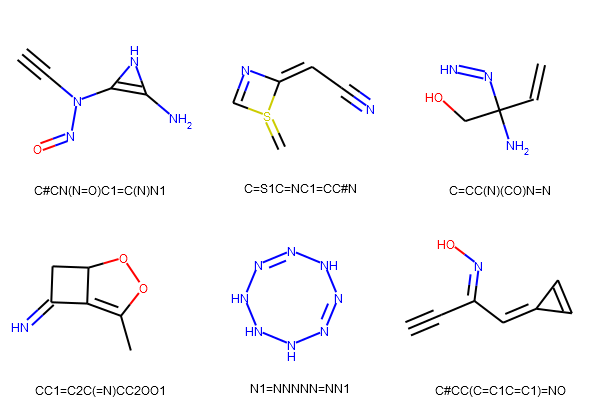

In [42]:
# Molecules chosen by NN
selected_molecules = select_molecules_by(nn_energy, chemspace['125_56k'], size=3*2)
img = Draw.MolsToGridImage(
        selected_molecules, 
        molsPerRow=3, 
        subImgSize=(200,200),
        legends=[Chem.MolToSmiles(mol) for mol in selected_molecules])
img.save('./figures/nn_mols_by_energy.pdf')
img

50 / 216
Feasbile molecules chosen. Time taken = 0.00600123405456543
accuracy = 0.9537037037037037
adjusted balanced accuracy = 0.8838554216867469
balanced accuracy = 0.9419277108433735
average precision = 0.8323646723646724
f1 score = 0.9019607843137256
precision = 0.8846153846153846
recall = 0.92
roc = 0.9419277108433735
confusion matrix
 = [[160   6]
 [  4  46]]


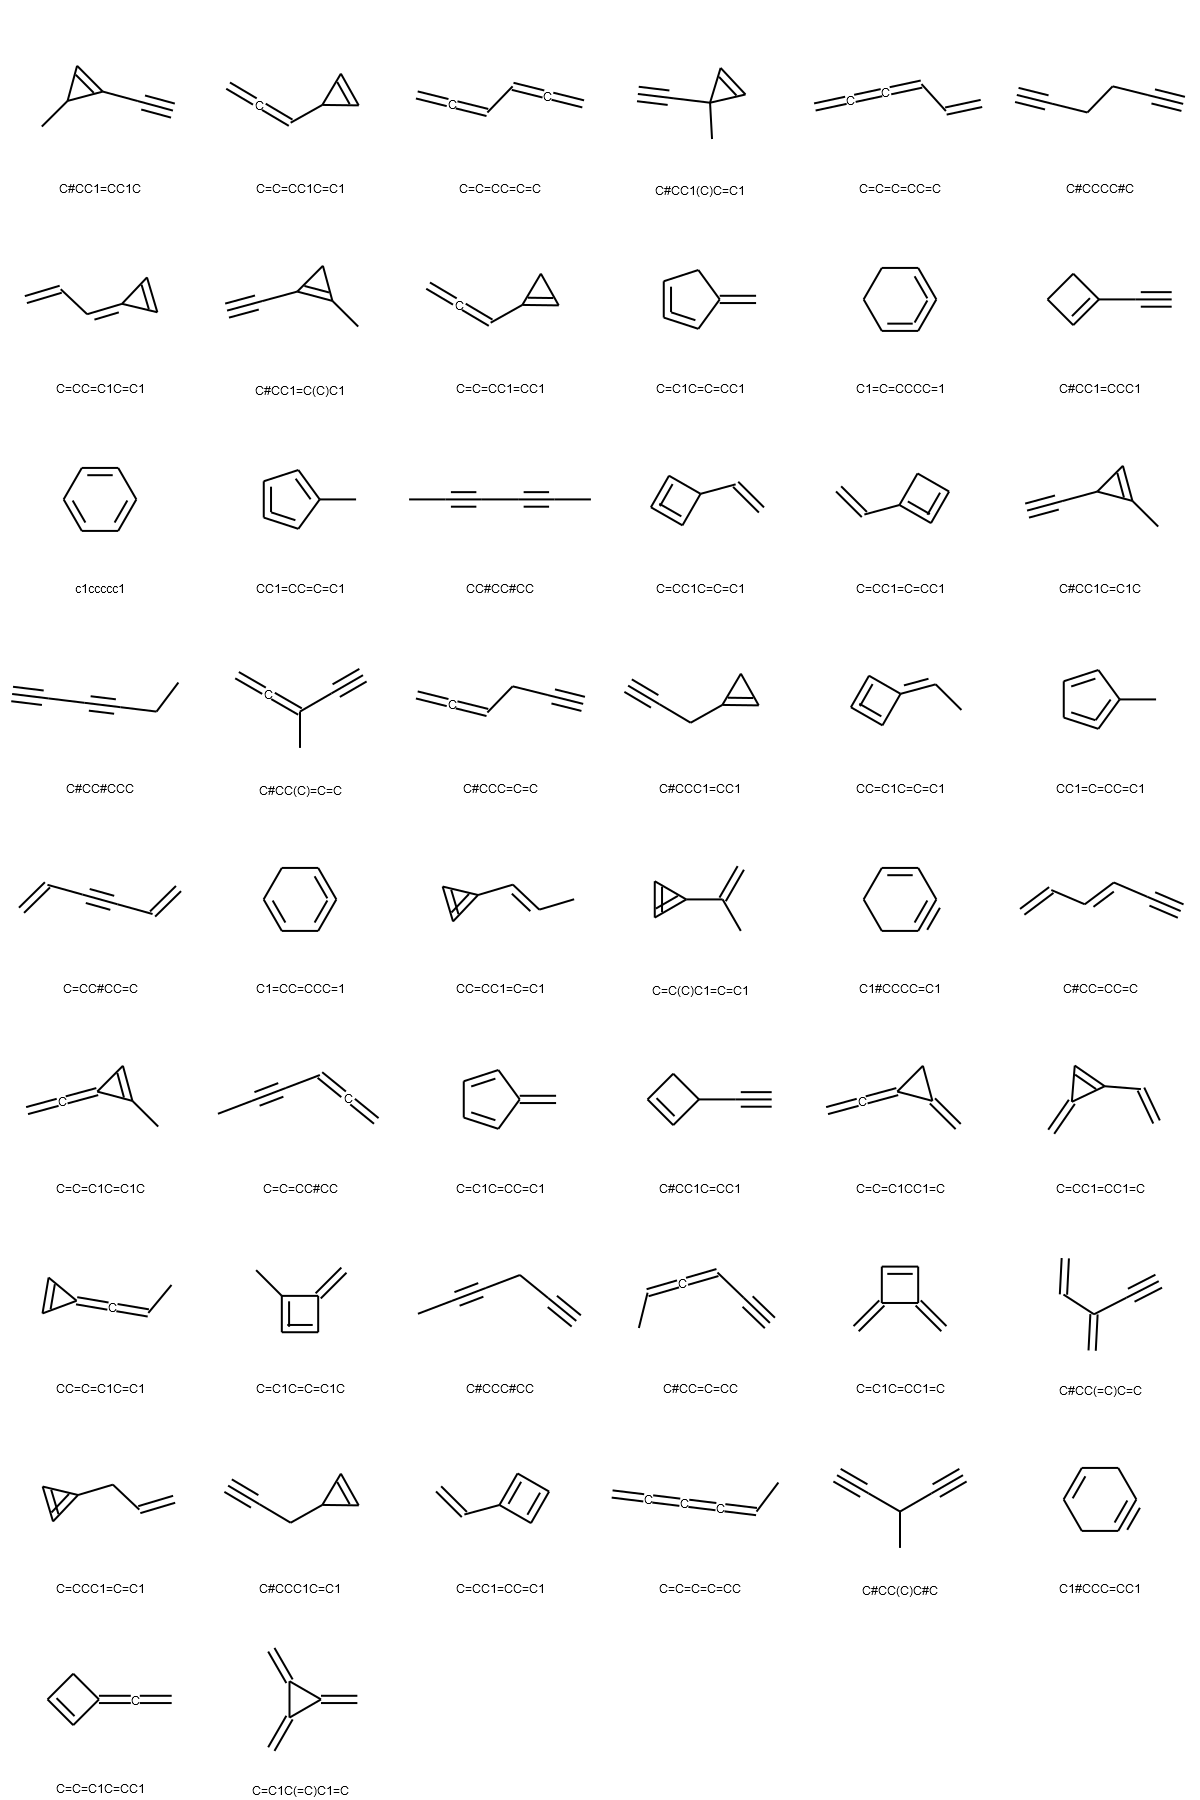

In [115]:
# Molecules chosen by NN
selected_molecules = select_molecules_by(nn_energy, chemspace['c6h6'], actuals=y_c6h6['energy_loss'], size=50)
img = Draw.MolsToGridImage(
        selected_molecules, 
        molsPerRow=6,
        subImgSize=(200,200),
        legends=[Chem.MolToSmiles(mol) for mol in selected_molecules])
img.save('./figures/c6h6_nn_energy.pdf')
img

51 / 216
Feasbile molecules chosen. Time taken = 0.0769956111907959
accuracy = 0.9398148148148148
adjusted balanced accuracy = 0.8399286987522281
balanced accuracy = 0.919964349376114
average precision = 0.791352438411262
f1 score = 0.8737864077669903
precision = 0.8653846153846154
recall = 0.8823529411764706
roc = 0.9199643493761139
confusion matrix
 = [[158   7]
 [  6  45]]


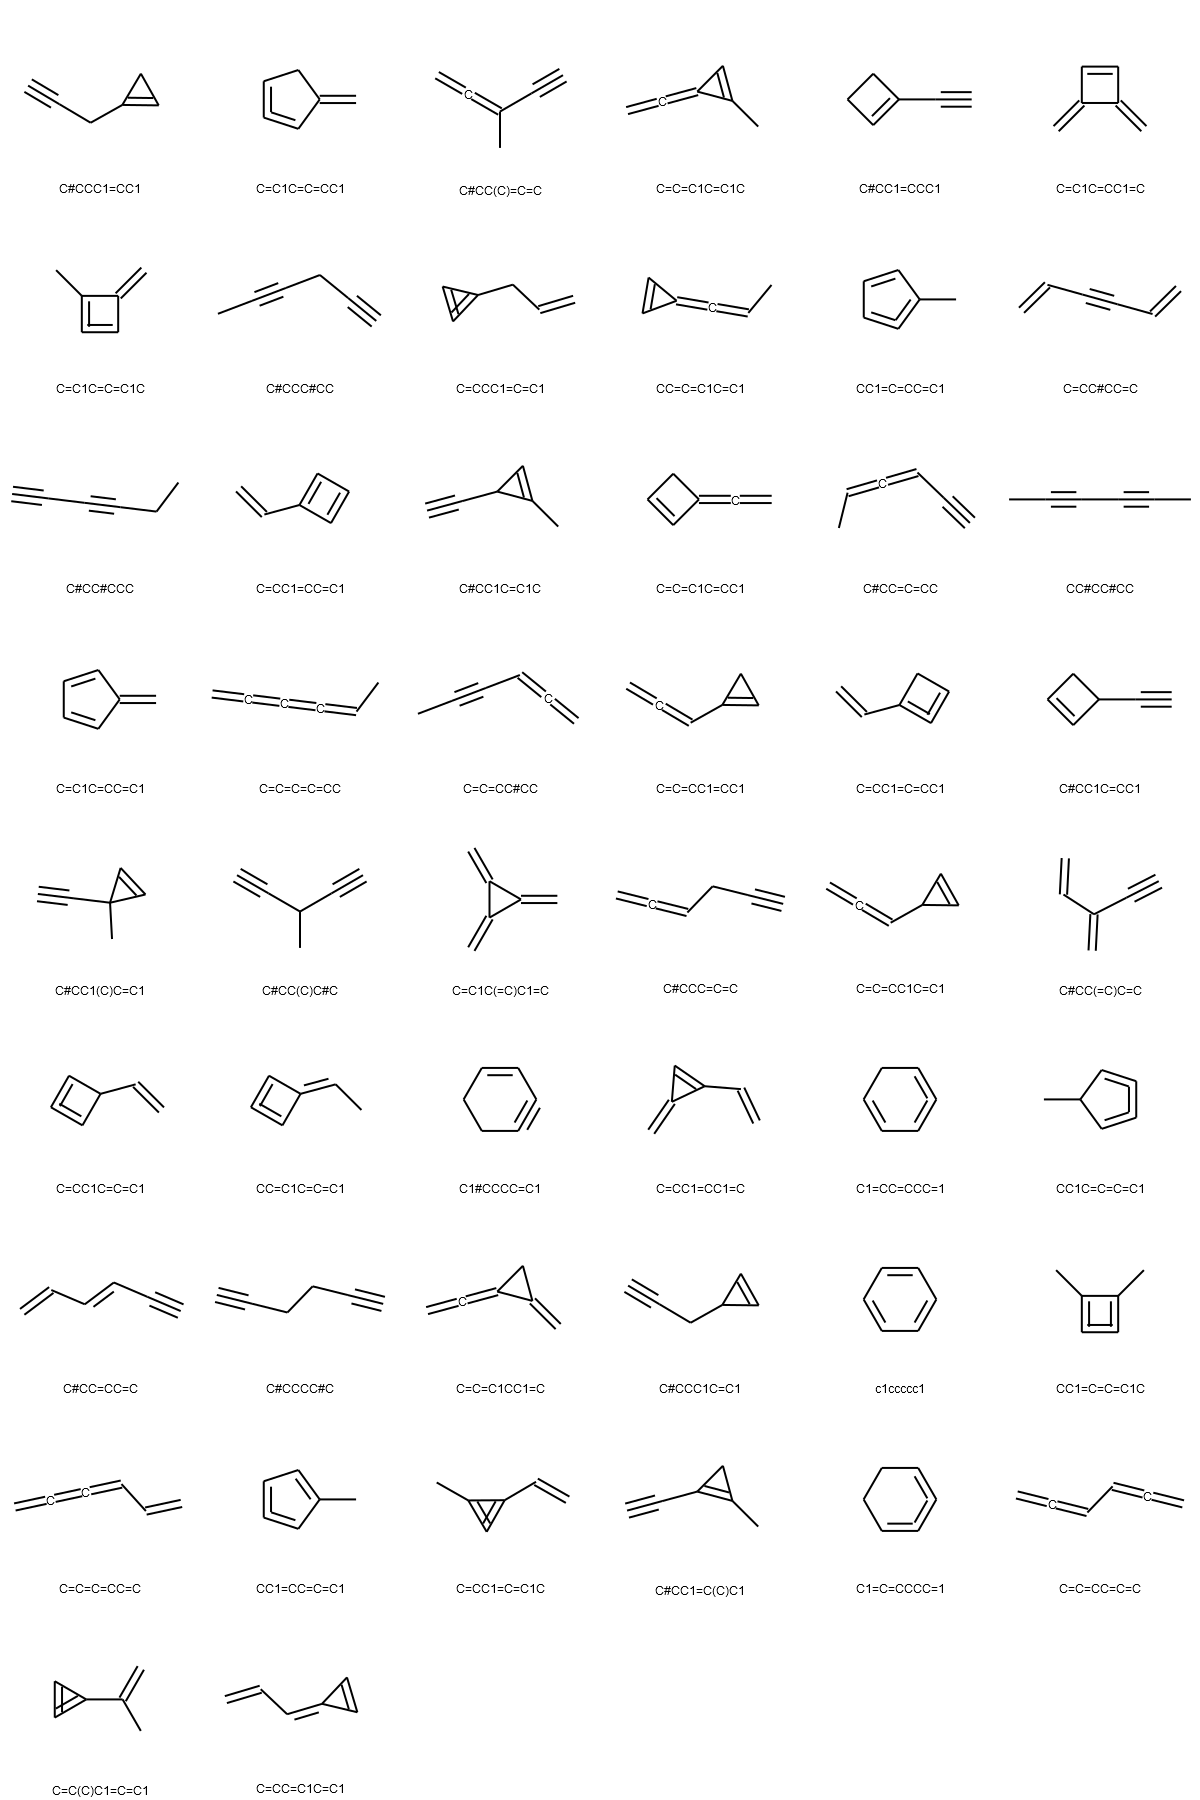

In [116]:
###### Molecules chosen by NN
selected_molecules = select_molecules_by(hgb_energy, chemspace['c6h6'], actuals=y_c6h6['energy_loss'], size=51)
img = Draw.MolsToGridImage(
        selected_molecules, 
        molsPerRow=6,
        subImgSize=(200,200),
        legends=[Chem.MolToSmiles(mol) for mol in selected_molecules])
img.save('./figures/c6h6_hgb_energy.pdf')
img

Taking length_loss of >= 0.011 as 'impossible'
Unconstructible molecules:
6 / 39
length_loss targets successfully computed. 

Taking angle_loss of >= 1.53 as 'impossible'
Unconstructible molecules:
31 / 39
angle_loss targets successfully computed. 

Taking energy_loss of >= 10.557 as 'impossible'
Unconstructible molecules:
24 / 39
energy_loss targets successfully computed. 

Features successfully computed 

15 / 39
Feasbile molecules chosen. Time taken = 0.004999876022338867
accuracy = 0.8974358974358975
adjusted balanced accuracy = 0.7833333333333332
balanced accuracy = 0.8916666666666666
average precision = 0.8023931623931625
f1 score = 0.8666666666666667
precision = 0.8666666666666667
recall = 0.8666666666666667
roc = 0.8916666666666666
confusion matrix
 = [[22  2]
 [ 2 13]]


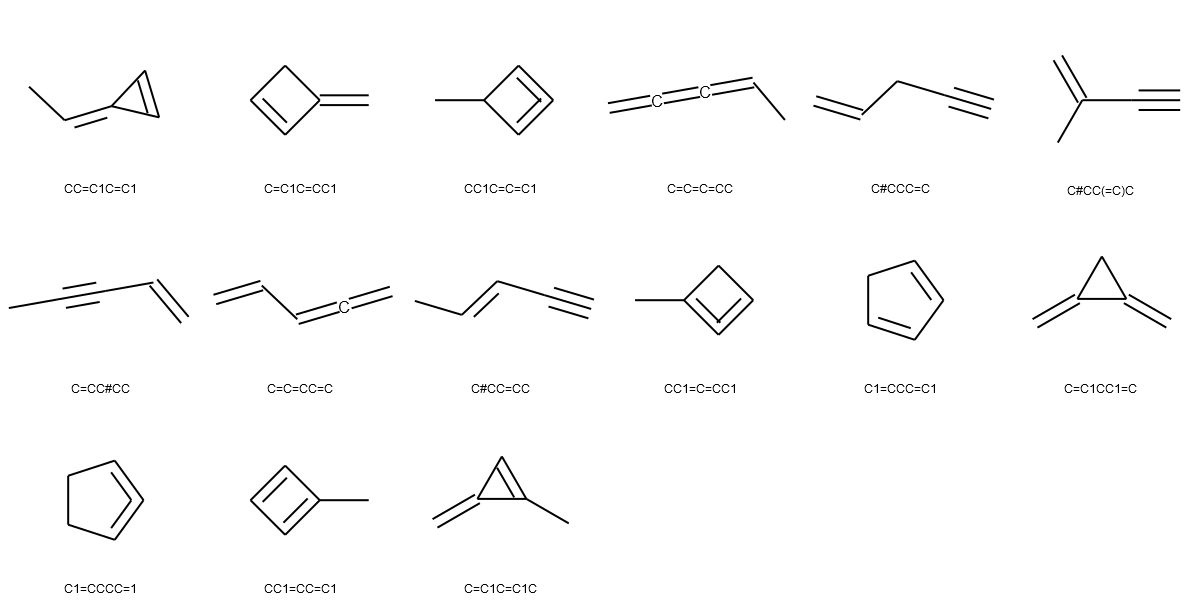

In [30]:
# Molecules chosen by NN
X_c5h6, y_c5h6 = prepare_training_data('c5h6', features_scaler=features_scaler)
selected_molecules = select_molecules_by(nn_energy, chemspace['c5h6'], actuals=y_c5h6['energy_loss'], size=15)
img = Draw.MolsToGridImage(
        selected_molecules, 
        molsPerRow=6,
        subImgSize=(200,200),
        legends=[Chem.MolToSmiles(mol) for mol in selected_molecules])
img.save('./figures/c5h6_nn_energy.pdf')
img

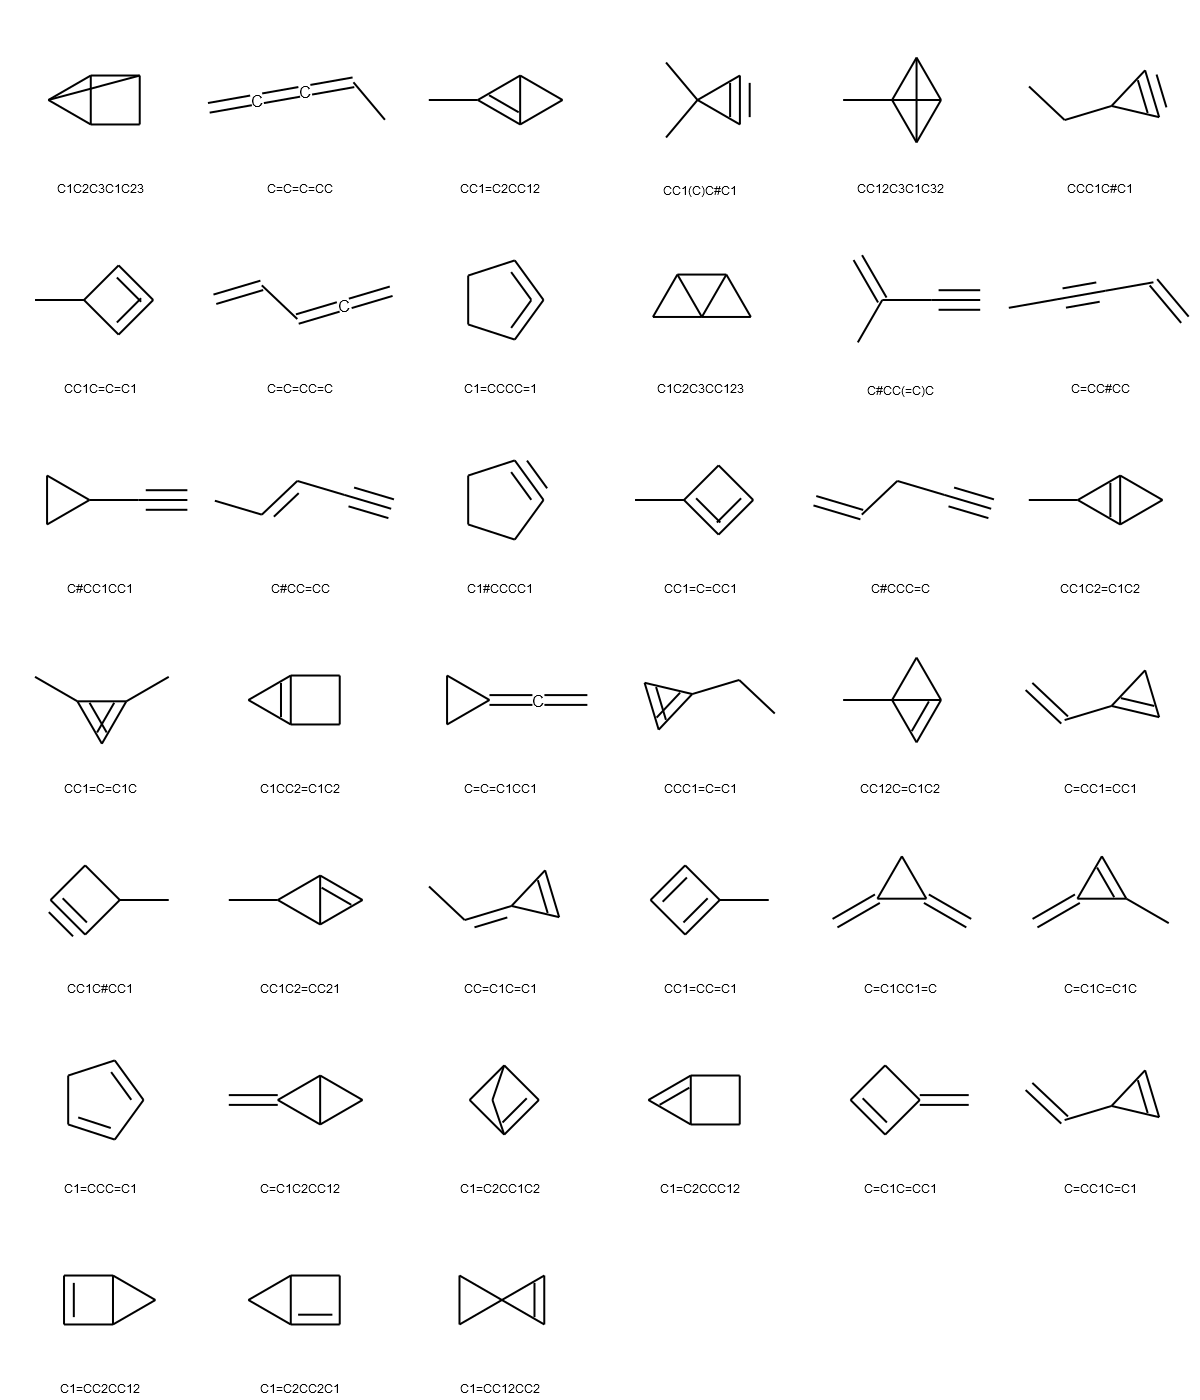

In [59]:
c5h6s = [mol for mol in chemspace['c5h6']['mols']]
img = Draw.MolsToGridImage(
        [mol for mol in chemspace['c5h6']['mols']], 
        molsPerRow=6,
        subImgSize=(200,200),
        legends=[Chem.MolToSmiles(mol) for mol in c5h6s])
img.save('./figures/c5h6.pdf')
img

In [31]:
X_c6h6, y_c6h6 = prepare_training_data('c6h6', features_scaler=features_scaler)

Taking length_loss of >= 0.011 as 'impossible'
Unconstructible molecules:
66 / 216
length_loss targets successfully computed. 

Taking angle_loss of >= 1.53 as 'impossible'
Unconstructible molecules:
199 / 216
angle_loss targets successfully computed. 

Taking energy_loss of >= 10.557 as 'impossible'
Unconstructible molecules:
164 / 216
energy_loss targets successfully computed. 

Features successfully computed 



In [44]:
evaluate_classifier(nn_energy, X_c6h6, y_c6h6['energy_loss'])
evaluate_classifier(hgb_energy, X_c6h6, y_c6h6['energy_loss'])

Testing results:
accuracy = 0.9537037037037037
adjusted balanced accuracy = 0.8602251407129455
balanced accuracy = 0.9301125703564728
average precision = 0.8416239316239317
f1 score = 0.9019607843137256
precision = 0.92
recall = 0.8846153846153846
roc = 0.9301125703564728
confusion matrix
 = [[160   4]
 [  6  46]]
Testing results:
accuracy = 0.9398148148148148
adjusted balanced accuracy = 0.8287992495309568
balanced accuracy = 0.9143996247654784
average precision = 0.7959820680408917
f1 score = 0.8737864077669903
precision = 0.8823529411764706
recall = 0.8653846153846154
roc = 0.9143996247654784
confusion matrix
 = [[158   6]
 [  7  45]]


In [45]:
evaluate_classifier(nn_angle, X_c6h6, y_c6h6['angle_loss'])
evaluate_classifier(hgb_angle, X_c6h6, y_c6h6['angle_loss'])

Testing results:
accuracy = 0.9398148148148148
adjusted balanced accuracy = 0.45048773278155485
balanced accuracy = 0.7252438663907774
average precision = 0.3553921568627451
f1 score = 0.5517241379310345
precision = 0.6666666666666666
recall = 0.47058823529411764
roc = 0.7252438663907774
confusion matrix
 = [[195   4]
 [  9   8]]
Testing results:
accuracy = 0.9537037037037037
adjusted balanced accuracy = 0.4117647058823528
balanced accuracy = 0.7058823529411764
average precision = 0.4580610021786492
f1 score = 0.5833333333333334
precision = 1.0
recall = 0.4117647058823529
roc = 0.7058823529411764
confusion matrix
 = [[199   0]
 [ 10   7]]


In [49]:
evaluate_classifier(nn_length, X_c6h6, y_c6h6['length_loss'])
evaluate_classifier(hgb_length, X_c6h6, y_c6h6['length_loss'])

Testing results:
accuracy = 0.9722222222222222
adjusted balanced accuracy = 0.9090909090909092
balanced accuracy = 0.9545454545454546
average precision = 0.9615384615384616
f1 score = 0.9803921568627451
precision = 0.9615384615384616
recall = 1.0
roc = 0.9545454545454545
confusion matrix
 = [[ 60   6]
 [  0 150]]
Testing results:
accuracy = 0.9675925925925926
adjusted balanced accuracy = 0.9024242424242424
balanced accuracy = 0.9512121212121212
average precision = 0.9595113500597372
f1 score = 0.9770491803278689
precision = 0.9612903225806452
recall = 0.9933333333333333
roc = 0.9512121212121212
confusion matrix
 = [[ 60   6]
 [  1 149]]


Proportion of $C_6H_6$ in the training set

In [27]:
c6h6_count = 0
c5h6_count = 0
for mol in chemspace['125_338k']['mols']:
    formula = Chem.rdMolDescriptors.CalcMolFormula(mol)
    if formula == 'C6H6':
        c6h6_count += 1
        print(f'C6H6 isomer: {Chem.MolToSmiles(mol)}')
    elif formula == 'C5H6':
        c5h6_count += 1
        print(f'C5H6 isomer: {Chem.MolToSmiles(mol)}')
print(f'Total of {c6h6_count} C6H6 isomers; {c5h6_count} C5H6 isomers in training/testing set')

C6H6 isomer: C=C=CC1=CC1
Total of 1 C6H6 isomers; 0 C5H6 isomers in training/testing set


In [44]:
# [1, 1, 1] propellane - why is it missing?!!?
Chem.CanonSmiles('C1(C2)(C3)C23C1')

'C1C23CC12C3'